# Final Notebook for BTCGraphGuard

**Authors: Xuhui Zhan, Tianhao Qu, Siyu Yang**


## Import Libraries

In [51]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import networkx as nx
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import from_networkx
import time

In [52]:
# Prepare Data
data_root = 'data/elliptic_bitcoin_dataset'
elliptic_txs_features = pd.read_csv(os.path.join(data_root, 'elliptic_txs_features.csv'), header=None)
elliptic_txs_edgelist = pd.read_csv(os.path.join(data_root, 'elliptic_txs_edgelist.csv'))
elliptic_txs_classes = pd.read_csv(os.path.join(data_root, 'elliptic_txs_classes.csv'))

elliptic_txs_features.columns = ['txId'] + [f'V{i}' for i in range(1, 167)]


In [53]:
print(elliptic_txs_features.shape)
print(elliptic_txs_edgelist.shape)
print(elliptic_txs_classes.shape)


(203769, 167)
(234355, 2)
(203769, 2)


In [54]:
elliptic_txs_classes['class_mapped'] = elliptic_txs_classes['class'].replace({'1': 'illicit', '2': 'licit'})

In [55]:
# Create Graph
G = nx.from_pandas_edgelist(elliptic_txs_edgelist, 'txId1', 'txId2')

## Random seed settings

In [56]:
RANDOM_STATE = 42
NUM_EPOCHS = 30

In [57]:
def set_seed_for_torch(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)      # For single-GPU.
        torch.cuda.manual_seed_all(seed)  # For multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def set_seed_for_numpy(seed):
    np.random.seed(seed) 
    
def set_seed_for_random(seed):
    random.seed(seed)  

In [58]:
set_seed_for_torch(RANDOM_STATE)
set_seed_for_numpy(RANDOM_STATE)
set_seed_for_random(RANDOM_STATE)

## EDA

In [59]:
# Spaceholders for EDA

## Preprocess Data

In [60]:
tx_id_mapping = {tx_id: idx for idx, tx_id in enumerate(elliptic_txs_features['txId'])}

# Create an explicit copy of the filtered DataFrame
edges_with_features = elliptic_txs_edgelist[elliptic_txs_edgelist['txId1'].isin(list(tx_id_mapping.keys())) & 
                                           elliptic_txs_edgelist['txId2'].isin(list(tx_id_mapping.keys()))].copy()

# Now use loc to set values (though with copy() above, direct assignment would also work)
edges_with_features.loc[:, 'Id1'] = edges_with_features['txId1'].map(tx_id_mapping)
edges_with_features.loc[:, 'Id2'] = edges_with_features['txId2'].map(tx_id_mapping)

In [61]:
edge_index = torch.tensor(edges_with_features[['Id1', 'Id2']].values.T, dtype=torch.long)
node_features = torch.tensor(elliptic_txs_features.drop(columns=['txId']).values, 
                             dtype=torch.float)

In [62]:
le = LabelEncoder()
class_labels = le.fit_transform(elliptic_txs_classes['class'])
node_labels = torch.tensor(class_labels, dtype=torch.long)
original_labels = le.inverse_transform(class_labels)

In [63]:
data = Data(x=node_features, 
            edge_index=edge_index, 
            y=node_labels)

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
known_mask   = (data.y == 0) | (data.y == 1)  # Only nodes with known labels licit or illicit
unknown_mask = data.y == 2                    # Nodes with unknown labels

In [66]:
num_known_nodes = known_mask.sum().item()
permutations = torch.randperm(num_known_nodes)
train_size = int(0.8 * num_known_nodes)
val_size = int(0.1 * num_known_nodes)
test_size = num_known_nodes - train_size - val_size

total = np.sum([train_size, val_size, test_size])

print(f"""Number of observations per split
    Training   : {train_size:10,} ({100*train_size/total:0.2f} %)
    Validation : {val_size:10,} ({100*val_size/total:0.2f} %)
    Testing    : {test_size:10,} ({100*test_size/total:0.2f} %)
""")

Number of observations per split
    Training   :     37,251 (80.00 %)
    Validation :      4,656 (10.00 %)
    Testing    :      4,657 (10.00 %)



In [67]:
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_indices = known_mask.nonzero(as_tuple=True)[0][permutations[:train_size]]
val_indices = known_mask.nonzero(as_tuple=True)[0][permutations[train_size:train_size + val_size]]
test_indices = known_mask.nonzero(as_tuple=True)[0][permutations[train_size + val_size:]]

data.train_mask[train_indices] = True
data.val_mask[val_indices] = True
data.test_mask[test_indices] = True

print(len(data.train_mask))

203769


In [68]:
print(data.keys())

['y', 'train_mask', 'test_mask', 'edge_index', 'x', 'val_mask']


## Graph attention network (GAT)

In [69]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

## GraphSAGE

In [70]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [71]:
def train_gnn_model(graph_data, checkpoint_path, model_args=None, num_epochs=200, lr=0.005, weight_decay=5e-4, verbose=True):
    """
    Train a Graph Neural Network model and save checkpoints.
    
    Args:
        graph_data (torch_geometric.data.Data): The prepared graph data
        checkpoint_path (str): Path to save model checkpoints
        model_args (dict, optional): Dictionary containing model parameters:
            - model_name: Type of GNN model ('GAT' or 'GraphSAGE')
            - input_dim: Input feature dimension
            - hidden_dim: Hidden layer dimension
            - output_dim: Output dimension (number of classes)
            - heads: Number of attention heads (for GAT, default: 8)
        num_epochs (int): Maximum number of training epochs
        lr (float): Learning rate for Adam optimizer
        weight_decay (float): Weight decay for regularization
        verbose (bool): Whether to print training progress
        
    Returns:
        dict: Dictionary containing trained model and training metrics
    """
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create output directory if it doesn't exist
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
    
    # Move data to device
    graph_data = graph_data.to(device)
    
    # Set default model args if not provided
    if model_args is None:
        model_args = {
            'model_name': 'GAT',  # Default to GAT if not specified
            'input_dim': graph_data.x.shape[1],
            'hidden_dim': 64,
            'output_dim': len(torch.unique(graph_data.y[graph_data.y != 2])),  # Exclude unknown class
            'heads': 8
        }
    
    # Initialize model based on model_name
    model_name = model_args.get('model_name', 'GAT')
    
    if model_name.upper() == 'GAT':
        model = GAT(
            input_dim=model_args['input_dim'],
            hidden_dim=model_args['hidden_dim'],
            output_dim=model_args['output_dim'],
            heads=model_args.get('heads', 8)
        ).to(device)
        model_type = 'GAT'
    elif model_name.upper() == 'GRAPHSAGE' or model_name.upper() == 'SAGE':
        model = GraphSAGE(
            input_dim=model_args['input_dim'],
            hidden_dim=model_args['hidden_dim'],
            output_dim=model_args['output_dim']
        ).to(device)
        model_type = 'GraphSAGE'
    else:
        raise ValueError(f"Unsupported model type: {model_name}. Use 'GAT' or 'GraphSAGE'.")
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Training function
    def train_step():
        model.train()
        optimizer.zero_grad()
        out = model(graph_data)
        loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
        loss.backward()
        optimizer.step()
        return loss.item()
    
    # Evaluation function
    def evaluate(mask):
        model.eval()
        with torch.no_grad():
            out = model(graph_data)
            pred = out.argmax(dim=1)
            correct = pred[mask] == graph_data.y[mask]
            acc = int(correct.sum()) / int(mask.sum())
        return acc
    
    # Training loop
    best_val_acc = 0
    best_model_state = None
    train_history = {
        'losses': [],
        'train_acc': [],
        'val_acc': []
    }
    
    start_time = time.time()
    for epoch in range(1, num_epochs + 1):
        loss = train_step()
        train_acc = evaluate(graph_data.train_mask)
        val_acc = evaluate(graph_data.val_mask)
        
        train_history['losses'].append(loss)
        train_history['train_acc'].append(train_acc)
        train_history['val_acc'].append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            torch.save(best_model_state, checkpoint_path)
            
        if verbose and epoch % 10 == 0:
            print(f'{model_type} Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    training_time = time.time() - start_time
    
    # Load best model and evaluate
    model.load_state_dict(best_model_state)
    test_acc = evaluate(graph_data.test_mask)
    
    if verbose:
        print(f'{model_type} Test Accuracy: {test_acc:.4f}')
        print(f'{model_type} Training Time: {training_time:.2f} seconds')
    
    return {
        'model': model,
        'best_model_state': best_model_state,
        'test_accuracy': test_acc,
        'val_accuracy': best_val_acc,
        'training_time': training_time,
        'training_history': train_history
    }

In [72]:
def inspect_model_results(results, save_dir=None, model_name="model"):
    """
    Inspects and visualizes the results from the train_gnn_model function.
    
    Args:
        results (dict): Results dictionary returned by train_gnn_model
        save_dir (str, optional): Directory to save visualizations and metrics
                                 If None, extracts directory from checkpoint path
        model_name (str): Name of the model for labeling plots and files
    """
    # Extract training history and metrics
    history = results['training_history']
    test_acc = results['test_accuracy']
    val_acc = results['val_accuracy']
    training_time = results['training_time']
    
    # Determine save directory
    if save_dir is None:
        if 'best_model_state' in results and isinstance(results['best_model_state'], str):
            save_dir = os.path.dirname(results['best_model_state'])
        else:
            save_dir = 'output'
    
    os.makedirs(save_dir, exist_ok=True)
    
    # Create figure with 2 subplots
    plt.figure(figsize=(15, 6))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    epochs = range(1, len(history['losses']) + 1)
    plt.plot(epochs, history['losses'], 'bo-', label='Training Loss')
    plt.title(f'{model_name} - Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'go-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Save figure
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{model_name}_training_history.png'), dpi=300)
    plt.close()
    
    # Print and save metrics
    metrics = {
        'Model': model_name,
        'Test Accuracy': f'{test_acc:.4f}',
        'Validation Accuracy': f'{val_acc:.4f}',
        'Training Time (s)': f'{training_time:.2f}',
        'Final Training Loss': f'{history["losses"][-1]:.4f}',
        'Number of Epochs': len(history['losses'])
    }
    
    print(f"\n{'='*20} {model_name} Results {'='*20}")
    for key, value in metrics.items():
        print(f"{key}: {value}")
    print(f"{'='*50}")
    
    # Save metrics to CSV
    pd.DataFrame([metrics]).to_csv(os.path.join(save_dir, f'{model_name}_metrics.csv'), index=False)
    
    # Create additional visualization: accuracy vs loss
    plt.figure(figsize=(10, 6))
    plt.scatter(history['losses'], history['val_acc'], c=range(len(history['losses'])), cmap='viridis', 
                s=100, alpha=0.7, edgecolors='black', linewidth=1)
    plt.colorbar(label='Epoch')
    plt.title(f'{model_name} - Validation Accuracy vs Training Loss')
    plt.xlabel('Training Loss')
    plt.ylabel('Validation Accuracy')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.savefig(os.path.join(save_dir, f'{model_name}_acc_vs_loss.png'), dpi=300)
    plt.close()
    
    return metrics

In [73]:
# input_dim = data.x.shape[1]
# hidden_dim = 64
# output_dim = len(torch.unique(data.y[data.y != 2]))

# gat_output_dir = 'output/GAT'

# # For GAT model
# gat_args = {
#     'model_name': 'GAT',
#     'input_dim': input_dim,
#     'hidden_dim': hidden_dim,
#     'output_dim': output_dim,
#     'heads': 8
# }

# gat_results = train_gnn_model(
#     graph_data=data,
#     checkpoint_path=os.path.join(gat_output_dir, "gat_best_model.pt"),
#     model_args=gat_args,
#     num_epochs=200,
#     verbose=True
# )



In [74]:
# sage_output_dir = 'output/GraphSAGE'

# # For GraphSAGE model
# sage_args = {
#     'model_name': 'GraphSAGE',
#     'input_dim': input_dim,
#     'hidden_dim': hidden_dim,
#     'output_dim': output_dim
# }

# sage_results = train_gnn_model(
#     graph_data=data,
#     checkpoint_path=os.path.join(sage_output_dir, "sage_best_model.pt"),
#     model_args=sage_args,
#     num_epochs=200,
#     verbose=True
# )

# metrics = inspect_model_results(sage_results)

## Augmented Graph labels by self-supervised-learning

In [75]:
def augment_labels(data, percentage=0.3, model=None):
    """
    Augments the training data by adding predicted labels for previously unknown nodes.
    
    Args:
        data (torch_geometric.data.Data): The input graph data
        percentage (float, optional): Percentage of unknown nodes to add to training. Defaults to 0.3.
        model (torch.nn.Module, optional): Pre-trained model to use for predictions. If None,
                                          uses label propagation for self-supervised learning.
    
    Returns:
        torch_geometric.data.Data: Augmented data with expanded training set
    """
    # Create a copy of the data to avoid modifying the original
    augmented_data = data.clone()
    device = augmented_data.x.device
    
    # Get masks for known and unknown labels
    known_mask = (augmented_data.y == 0) | (augmented_data.y == 1)
    unknown_mask = augmented_data.y == 2
    
    # Count unknown nodes and calculate how many to add
    num_unknown = unknown_mask.sum().item()
    num_to_add = int(num_unknown * percentage)
    
    if model is None:
        # Self-supervised learning approach using simple propagation
        print(f"Using self-supervised learning for label augmentation")
        
        # Create graph from data
        G = nx.Graph()
        edge_index = augmented_data.edge_index.cpu().numpy()
        
        # Add nodes and edges to the graph
        for i in range(augmented_data.num_nodes):
            G.add_node(i)
            
        for i in range(edge_index.shape[1]):
            G.add_edge(edge_index[0, i], edge_index[1, i])
        
        # Simple label propagation implementation
        predicted_labels = torch.zeros_like(augmented_data.y)
        confidence_scores = torch.zeros(len(augmented_data.y))
        
        # For each unknown node, check neighbors' labels
        for node in range(len(augmented_data.y)):
            if unknown_mask[node]:
                # Get all neighbors
                neighbors = list(G.neighbors(node))
                if not neighbors:
                    continue
                
                # Count labels of neighbors
                label_count = {0: 0, 1: 0}
                neighbor_features = []
                
                for neighbor in neighbors:
                    if known_mask[neighbor]:
                        neighbor_label = augmented_data.y[neighbor].item()
                        label_count[neighbor_label] = label_count.get(neighbor_label, 0) + 1
                        neighbor_features.append(augmented_data.x[neighbor])
                
                # If we have neighbors with known labels
                if sum(label_count.values()) > 0:
                    # Assign most frequent label
                    if label_count[0] > label_count[1]:
                        predicted_labels[node] = 0
                        confidence_scores[node] = label_count[0] / (label_count[0] + label_count[1])
                    elif label_count[1] > 0:
                        predicted_labels[node] = 1
                        confidence_scores[node] = label_count[1] / (label_count[0] + label_count[1])
                else:
                    # If no neighbors have known labels, look at second-degree neighbors
                    second_degree_neighbors = []
                    for neighbor in neighbors:
                        second_degree_neighbors.extend(list(G.neighbors(neighbor)))
                    
                    # Remove duplicates and the original node
                    second_degree_neighbors = list(set(second_degree_neighbors))
                    if node in second_degree_neighbors:
                        second_degree_neighbors.remove(node)
                    
                    # Count labels of second-degree neighbors
                    second_label_count = {0: 0, 1: 0}
                    for neighbor in second_degree_neighbors:
                        if known_mask[neighbor]:
                            neighbor_label = augmented_data.y[neighbor].item()
                            second_label_count[neighbor_label] = second_label_count.get(neighbor_label, 0) + 1
                    
                    # Assign most frequent label from second-degree neighbors
                    if sum(second_label_count.values()) > 0:
                        if second_label_count[0] > second_label_count[1]:
                            predicted_labels[node] = 0
                            confidence_scores[node] = second_label_count[0] / (second_label_count[0] + second_label_count[1])
                        elif second_label_count[1] > 0:
                            predicted_labels[node] = 1
                            confidence_scores[node] = second_label_count[1] / (second_label_count[0] + second_label_count[1])
    else:
        # Use the provided model for predictions
        print(f"Using provided model for label augmentation")
        model.eval()
        with torch.no_grad():
            out = model(augmented_data)
            probabilities = F.softmax(out, dim=1)
            
            # Get the highest probability and corresponding class
            confidence_scores, predicted_labels = probabilities.max(dim=1)
    
    # Select the top confident predictions among unknown nodes
    unknown_indices = unknown_mask.nonzero(as_tuple=True)[0]
    unknown_confidence = confidence_scores[unknown_indices]
    
    # Sort by confidence
    sorted_indices = unknown_confidence.argsort(descending=True)
    top_indices = unknown_indices[sorted_indices[:num_to_add]]
    
    # Update labels and training mask for selected nodes
    augmented_data.y[top_indices] = predicted_labels[top_indices]
    augmented_data.train_mask[top_indices] = True
    
    # Print statistics
    added_illicit = (predicted_labels[top_indices] == 1).sum().item()
    added_licit = (predicted_labels[top_indices] == 0).sum().item()
    
    print(f"Added {num_to_add} previously unknown nodes to training set:")
    print(f"  - Predicted illicit: {added_illicit} ({100*added_illicit/num_to_add:.2f}%)")
    print(f"  - Predicted licit: {added_licit} ({100*added_licit/num_to_add:.2f}%)")
    
    return augmented_data

In [76]:
# augment_data = augment_labels(data)

In [77]:
# sage_model = GraphSAGE(input_dim, hidden_dim, output_dim)
# sage_model.load_state_dict(torch.load(os.path.join(sage_output_dir, "sage_best_model.pt")))
# augment_data_sage = augment_labels(data, model=sage_model)

## Subgraph Property Analysis

In [78]:
def analyze_graph_properties(data, model=None, save_dir='output/graph_analysis', verbose=True):
    """
    Analyzes subgraph properties for different node types (train/val/test/unknown) and labels.
    
    Args:
        data (torch_geometric.data.Data): The graph data object
        model (torch.nn.Module, optional): Model to predict unknown node labels
        save_dir (str): Directory to save results and plots
        verbose (bool): Whether to print detailed information
        
    Returns:
        dict: Dictionary containing all computed metrics
    """
    import os
    import pandas as pd
    import numpy as np
    import networkx as nx
    import matplotlib.pyplot as plt
    import seaborn as sns
    from torch_geometric.utils import to_networkx
    import torch.nn.functional as F
    
    # Create output directory
    os.makedirs(save_dir, exist_ok=True)
    
    # Convert to NetworkX graph for analysis
    G = to_networkx(data, to_undirected=True)
    
    # Define label names
    label_names = {
        0: 'licit',
        1: 'illicit',
        2: 'unknown'
    }
    
    # Create dictionaries to store metrics
    metrics = {}
    node_metrics = []
    
    # Calculate degree centrality for all nodes (to avoid recalculation)
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, k=min(100, len(G.nodes())), seed=42)
    
    try:
        closeness_centrality = nx.closeness_centrality(G)
    except:
        if verbose:
            print("Warning: Could not compute closeness centrality for the full graph (likely disconnected)")
        closeness_centrality = {node: 0 for node in G.nodes()}
    
    try:
        eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    except:
        if verbose:
            print("Warning: Eigenvector centrality did not converge, using approximate method")
        try:
            eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
        except:
            if verbose:
                print("Warning: Could not compute eigenvector centrality, using zeros")
            eigenvector_centrality = {node: 0 for node in G.nodes()}
            
    clustering_coefficients = nx.clustering(G)
    
    # First, analyze known nodes (train/val/test) by their actual labels
    for split_name in ['train', 'val', 'test']:
        split_mask = getattr(data, f'{split_name}_mask')
        
        for label in [0, 1]:  # 0: licit, 1: illicit
            # Create mask for this split+label combination
            combined_mask = split_mask & (data.y == label)
            node_indices = combined_mask.nonzero(as_tuple=True)[0].cpu().numpy()
            
            if len(node_indices) == 0:
                if verbose:
                    print(f"No nodes found for {split_name}_{label_names[label]}")
                continue
            
            # Name for this subgroup
            group_name = f"{split_name}_{label_names[label]}"
            
            # Process this subgroup
            process_node_group(G, node_indices, group_name, metrics, node_metrics,
                             degree_centrality, betweenness_centrality, 
                             closeness_centrality, eigenvector_centrality,
                             clustering_coefficients, verbose)
    
    # Then, analyze unknown nodes, splitting by predicted labels if model is provided
    unknown_mask = (data.y == 2)
    unknown_indices = unknown_mask.nonzero(as_tuple=True)[0]
    
    if len(unknown_indices) > 0:
        if model is None:
            # If no model, just analyze unknown nodes as one group
            group_name = "unknown"
            process_node_group(G, unknown_indices.cpu().numpy(), group_name, metrics, node_metrics,
                             degree_centrality, betweenness_centrality, 
                             closeness_centrality, eigenvector_centrality,
                             clustering_coefficients, verbose)
        else:
            # Use model to predict labels for unknown nodes
            model.eval()
            with torch.no_grad():
                out = model(data)
                pred_probs = F.softmax(out, dim=1)
                pred_labels = pred_probs.argmax(dim=1)
                
                # Get indices for unknown nodes predicted as licit/illicit
                pred_unknown_licit = unknown_mask & (pred_labels == 0)
                pred_unknown_illicit = unknown_mask & (pred_labels == 1)
                
                # Process predicted licit unknown nodes
                pred_licit_indices = pred_unknown_licit.nonzero(as_tuple=True)[0].cpu().numpy()
                if len(pred_licit_indices) > 0:
                    group_name = "pred_unknown_licit"
                    process_node_group(G, pred_licit_indices, group_name, metrics, node_metrics,
                                     degree_centrality, betweenness_centrality, 
                                     closeness_centrality, eigenvector_centrality,
                                     clustering_coefficients, verbose)
                    
                # Process predicted illicit unknown nodes
                pred_illicit_indices = pred_unknown_illicit.nonzero(as_tuple=True)[0].cpu().numpy()
                if len(pred_illicit_indices) > 0:
                    group_name = "pred_unknown_illicit"
                    process_node_group(G, pred_illicit_indices, group_name, metrics, node_metrics,
                                     degree_centrality, betweenness_centrality, 
                                     closeness_centrality, eigenvector_centrality,
                                     clustering_coefficients, verbose)
                
                # Print statistics about predictions
                if verbose:
                    total_unknown = len(unknown_indices)
                    pred_licit_count = len(pred_licit_indices)
                    pred_illicit_count = len(pred_illicit_indices)
                    print(f"Unknown nodes ({total_unknown}) predicted as:")
                    print(f"  - Licit: {pred_licit_count} ({100*pred_licit_count/total_unknown:.2f}%)")
                    print(f"  - Illicit: {pred_illicit_count} ({100*pred_illicit_count/total_unknown:.2f}%)")
    
    # Create a DataFrame with all node-level metrics
    node_df = pd.DataFrame(node_metrics)
    
    # Save node-level metrics
    node_df.to_csv(os.path.join(save_dir, 'node_metrics.csv'), index=False)
    
    # Save graph-level metrics
    graph_metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
    graph_metrics_df.to_csv(os.path.join(save_dir, 'graph_metrics.csv'))
    
    # Create visualizations
    create_visualizations(metrics, node_df, save_dir)
    
    if verbose:
        print(f"Analysis complete. Results saved to {save_dir}")
    
    return metrics

def process_node_group(G, node_indices, group_name, metrics, node_metrics,
                     degree_centrality, betweenness_centrality, 
                     closeness_centrality, eigenvector_centrality,
                     clustering_coefficients, verbose):
    """Helper function to process a group of nodes and calculate metrics"""
    
    # Extract the subgraph
    subgraph = G.subgraph(node_indices)
    
    # Calculate graph-level metrics
    group_metrics = {
        'num_nodes': len(subgraph),
        'num_edges': subgraph.number_of_edges(),
        'density': nx.density(subgraph),
        'avg_degree': np.mean([d for _, d in subgraph.degree()]) if len(subgraph) > 0 else 0,
        'avg_clustering': np.mean([clustering_coefficients.get(node, 0) for node in subgraph.nodes()]),
    }
    
    # Calculate connected components
    connected_components = list(nx.connected_components(subgraph))
    group_metrics['num_components'] = len(connected_components)
    
    if len(connected_components) > 0:
        largest_cc_size = max([len(cc) for cc in connected_components])
        group_metrics['largest_component_size'] = largest_cc_size
        group_metrics['largest_component_ratio'] = largest_cc_size / len(subgraph) if len(subgraph) > 0 else 0
    else:
        group_metrics['largest_component_size'] = 0
        group_metrics['largest_component_ratio'] = 0
    
    # Calculate centrality averages
    group_metrics['avg_degree_centrality'] = np.mean([degree_centrality.get(node, 0) for node in subgraph.nodes()])
    group_metrics['avg_betweenness_centrality'] = np.mean([betweenness_centrality.get(node, 0) for node in subgraph.nodes()])
    group_metrics['avg_closeness_centrality'] = np.mean([closeness_centrality.get(node, 0) for node in subgraph.nodes()])
    group_metrics['avg_eigenvector_centrality'] = np.mean([eigenvector_centrality.get(node, 0) for node in subgraph.nodes()])
    
    # Add homophily measure - how many edges connect to same-group nodes
    internal_edges = 0
    external_edges = 0
    
    node_set = set(node_indices)
    for node in subgraph:
        for neighbor in G.neighbors(node):
            if neighbor in node_set:
                internal_edges += 1
            else:
                external_edges += 1
    
    # Each internal edge is counted twice (once from each end)
    internal_edges = internal_edges / 2
    group_metrics['internal_edges'] = internal_edges
    group_metrics['external_edges'] = external_edges
    group_metrics['homophily'] = internal_edges / (internal_edges + external_edges) if (internal_edges + external_edges) > 0 else 0
    
    # Store the metrics for this group
    metrics[group_name] = group_metrics
    
    # Also store node-level metrics for later visualization
    for node in subgraph.nodes():
        node_metrics.append({
            'node_id': node,
            'group': group_name,
            'degree': G.degree(node),
            'degree_centrality': degree_centrality.get(node, 0),
            'betweenness_centrality': betweenness_centrality.get(node, 0),
            'closeness_centrality': closeness_centrality.get(node, 0),
            'eigenvector_centrality': eigenvector_centrality.get(node, 0),
            'clustering_coefficient': clustering_coefficients.get(node, 0)
        })
    
    if verbose:
        print(f"Processed {group_name}: {len(subgraph)} nodes, {subgraph.number_of_edges()} edges")

def create_visualizations(metrics, node_df, save_dir):
    """Create and save visualizations of the graph metrics"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import os
    
    # Set the style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Convert metrics to DataFrame for easier plotting
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
    
    # 1. Centrality comparison between groups
    centrality_metrics = ['avg_degree_centrality', 'avg_betweenness_centrality', 
                          'avg_closeness_centrality', 'avg_eigenvector_centrality']
    
    plt.figure(figsize=(12, 8))
    metrics_df[centrality_metrics].plot(kind='bar', figsize=(15, 6))
    plt.title('Average Centrality Metrics by Group')
    plt.ylabel('Centrality Value')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'centrality_by_group.png'), dpi=300)
    plt.close()
    
    # 2. Homophily and connectivity
    connectivity_metrics = ['density', 'homophily', 'avg_clustering', 'largest_component_ratio']
    
    plt.figure(figsize=(12, 8))
    metrics_df[connectivity_metrics].plot(kind='bar', figsize=(15, 6))
    plt.title('Connectivity Metrics by Group')
    plt.ylabel('Value')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'connectivity_by_group.png'), dpi=300)
    plt.close()
    
    # 3. Node and edge count
    plt.figure(figsize=(12, 8))
    ax = metrics_df[['num_nodes', 'num_edges']].plot(kind='bar', figsize=(15, 6))
    plt.title('Node and Edge Count by Group')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'node_edge_count.png'), dpi=300)
    plt.close()
    
    # 4. Scatter plot of centrality metrics for nodes
    centrality_pairs = [
        ('degree_centrality', 'betweenness_centrality'),
        ('degree_centrality', 'eigenvector_centrality'),
        ('closeness_centrality', 'eigenvector_centrality')
    ]
    
    # Define a color map for consistent group coloring
    group_order = node_df['group'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(group_order)))
    group_colors = {group: colors[i] for i, group in enumerate(group_order)}
    
    for x_metric, y_metric in centrality_pairs:
        plt.figure(figsize=(10, 8))
        
        for group in group_order:
            group_data = node_df[node_df['group'] == group]
            plt.scatter(
                group_data[x_metric], 
                group_data[y_metric],
                alpha=0.6, 
                label=group,
                color=group_colors[group],
                s=50
            )
        
        plt.title(f'{y_metric.replace("_", " ").title()} vs {x_metric.replace("_", " ").title()}')
        plt.xlabel(x_metric.replace("_", " ").title())
        plt.ylabel(y_metric.replace("_", " ").title())
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'scatter_{x_metric}_vs_{y_metric}.png'), dpi=300)
        plt.close()
    
    # 5. Distribution of degree centrality by group
    plt.figure(figsize=(12, 8))
    for group in group_order:
        group_data = node_df[node_df['group'] == group]
        sns.kdeplot(group_data['degree_centrality'], label=group)
    
    plt.title('Distribution of Degree Centrality by Group')
    plt.xlabel('Degree Centrality')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'degree_centrality_distribution.png'), dpi=300)
    plt.close()
    
    # 6. Heatmap of metrics correlation
    plt.figure(figsize=(10, 8))
    correlation = metrics_df.corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Between Graph Metrics')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'metrics_correlation.png'), dpi=300)
    plt.close()

In [79]:
# # Analysis with original data
# original_metrics = analyze_graph_properties(
#     data, 
#     save_dir='output/graph_analysis/original',
#     verbose=True
# )

# # Analysis with model predictions
# sage_metrics = analyze_graph_properties(
#     data,
#     model=sage_model,  # Using SAGE model for predictions
#     save_dir='output/graph_analysis/model_predictions',
#     verbose=True
# )

# Compare metrics between original and predicted
def compare_metrics(original_metrics, predicted_metrics, save_path='output/graph_analysis/metrics_comparison.csv'):
    """Compare metrics between original and predicted data"""
    import pandas as pd
    
    # Create DataFrames
    original_df = pd.DataFrame.from_dict(original_metrics, orient='index')
    predicted_df = pd.DataFrame.from_dict(predicted_metrics, orient='index')
    
    # Common groups (like train_licit, train_illicit, etc.)
    common_groups = set(original_df.index).intersection(set(predicted_df.index))
    
    # Compare metrics for common groups
    comparison = {}
    for group in common_groups:
        group_comparison = {}
        for metric in original_df.columns:
            original_value = original_df.loc[group, metric]
            predicted_value = predicted_df.loc[group, metric]
            difference = predicted_value - original_value
            percent_change = (difference / original_value) * 100 if original_value != 0 else float('inf')
            
            group_comparison[f"{metric}_original"] = original_value
            group_comparison[f"{metric}_predicted"] = predicted_value
            group_comparison[f"{metric}_diff"] = difference
            group_comparison[f"{metric}_pct_change"] = percent_change
            
        comparison[group] = group_comparison
    
    # Convert to DataFrame and save
    comparison_df = pd.DataFrame.from_dict(comparison, orient='index')
    comparison_df.to_csv(save_path)
    
    print(f"Metrics comparison saved to {save_path}")
    return comparison_df

# # Execute comparison
# comparison = compare_metrics(original_metrics, sage_metrics)

# # Print key findings
# print("\n==== KEY FINDINGS ====")
# print("Top metrics differences between original and predicted data:")

# # Find top 5 metrics with largest percent changes
# for group in comparison.index:
#     pct_change_cols = [col for col in comparison.columns if col.endswith('_pct_change')]
#     largest_changes = comparison.loc[group, pct_change_cols].abs().nlargest(5)
    
#     print(f"\nGroup: {group}")
#     for metric in largest_changes.index:
#         base_metric = metric.replace('_pct_change', '')
#         original = comparison.loc[group, f"{base_metric}_original"]
#         predicted = comparison.loc[group, f"{base_metric}_predicted"]
#         pct_change = comparison.loc[group, metric]
        
#         change_direction = "increased" if pct_change > 0 else "decreased"
#         print(f"  {base_metric}: {original:.4f} → {predicted:.4f} ({change_direction} by {abs(pct_change):.2f}%)")

## Overall comparison

In [80]:
def compare_subgraph_properties(
    original_metrics, 
    predicted_metrics, 
    save_dir,
    prefix="comparison",
    key_metrics=None
):
    """
    Compare subgraph properties between licit and illicit nodes across different datasets.
    
    Args:
        original_metrics (dict): Metrics from original known nodes
        predicted_metrics (dict): Metrics from nodes with predicted labels
        save_dir (str): Directory to save comparison results
        prefix (str): Prefix for saved files
        key_metrics (list, optional): Key metrics to focus on
        
    Returns:
        dict: Comparison results
    """
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    os.makedirs(save_dir, exist_ok=True)
    
    # Define key metrics if not provided
    if key_metrics is None:
        key_metrics = [
            'homophily', 'density', 'avg_clustering', 'avg_degree_centrality',
            'avg_betweenness_centrality', 'largest_component_ratio'
        ]
    
    # Extract metrics for licit and illicit nodes
    original_licit = {}
    original_illicit = {}
    predicted_licit = {}
    predicted_illicit = {}
    
    # Find relevant groups in original metrics
    for group, metrics in original_metrics.items():
        if 'licit' in group:
            if 'illicit' in group:
                original_illicit[group] = metrics
            else:
                original_licit[group] = metrics
    
    # Find relevant groups in predicted metrics
    for group, metrics in predicted_metrics.items():
        if 'pred' in group or 'unknown' in group:
            if 'illicit' in group:
                predicted_illicit[group] = metrics
            elif 'licit' in group:
                predicted_licit[group] = metrics
    
    # Prepare data for comparison
    comparison_data = []
    
    # Compare key metrics between original and predicted
    for metric in key_metrics:
        # Original licit metrics (average across train/val/test if available)
        orig_licit_values = [m.get(metric, 0) for m in original_licit.values() if metric in m]
        orig_licit_avg = np.mean(orig_licit_values) if orig_licit_values else 0
        
        # Original illicit metrics
        orig_illicit_values = [m.get(metric, 0) for m in original_illicit.values() if metric in m]
        orig_illicit_avg = np.mean(orig_illicit_values) if orig_illicit_values else 0
        
        # Predicted licit metrics
        pred_licit_values = [m.get(metric, 0) for m in predicted_licit.values() if metric in m]
        pred_licit_avg = np.mean(pred_licit_values) if pred_licit_values else 0
        
        # Predicted illicit metrics
        pred_illicit_values = [m.get(metric, 0) for m in predicted_illicit.values() if metric in m]
        pred_illicit_avg = np.mean(pred_illicit_values) if pred_illicit_values else 0
        
        # Calculate similarity scores
        licit_similarity = 1 - min(1, abs(pred_licit_avg - orig_licit_avg) / max(0.0001, abs(orig_licit_avg)))
        illicit_similarity = 1 - min(1, abs(pred_illicit_avg - orig_illicit_avg) / max(0.0001, abs(orig_illicit_avg)))
        
        comparison_data.append({
            'metric': metric,
            'original_licit': orig_licit_avg,
            'original_illicit': orig_illicit_avg,
            'predicted_licit': pred_licit_avg,
            'predicted_illicit': pred_illicit_avg,
            'licit_similarity': licit_similarity,
            'illicit_similarity': illicit_similarity,
            'overall_similarity': (licit_similarity + illicit_similarity) / 2
        })
    
    # Convert to DataFrame
    df = pd.DataFrame(comparison_data)
    
    # Save comparison data
    df.to_csv(os.path.join(save_dir, f"{prefix}_subgraph_comparison.csv"), index=False)
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot comparison of key metrics
    for i, metric in enumerate(key_metrics):
        if i >= len(df):
            continue
            
        metric_data = df[df['metric'] == metric].iloc[0]
        
        plt.subplot(3, 2, i+1)
        
        # Create grouped bar chart
        labels = ['Original', 'Predicted']
        licit_values = [metric_data['original_licit'], metric_data['predicted_licit']]
        illicit_values = [metric_data['original_illicit'], metric_data['predicted_illicit']]
        
        x = np.arange(len(labels))
        width = 0.35
        
        plt.bar(x - width/2, licit_values, width, label='Licit', color='green')
        plt.bar(x + width/2, illicit_values, width, label='Illicit', color='red')
        
        plt.xlabel('Data Source')
        plt.ylabel(metric)
        plt.title(f'{metric} Comparison (Similarity: {metric_data["overall_similarity"]:.2f})')
        plt.xticks(x, labels)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{prefix}_metrics_comparison.png"), dpi=300)
    plt.close()
    
    # Calculate overall similarity
    overall_similarity = df['overall_similarity'].mean()
    
    # Create summary plot
    plt.figure(figsize=(12, 6))
    plt.bar(df['metric'], df['overall_similarity'], color='blue')
    plt.title(f'Subgraph Property Similarity (Overall: {overall_similarity:.4f})')
    plt.xlabel('Metric')
    plt.ylabel('Similarity Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{prefix}_overall_similarity.png"), dpi=300)
    plt.close()
    
    return {
        'comparison_data': df,
        'overall_similarity': overall_similarity
    }

In [81]:
def comprehensive_graph_analysis(
    data, 
    output_dir='output/comprehensive_analysis',
    model_configs=None,
    augment_percentage=0.3,
    epochs=100,
    random_seed=42,
    verbose=True
):
    """
    Performs comprehensive analysis of graph augmentation methods.
    
    Args:
        data (torch_geometric.data.Data): The input graph data
        output_dir (str): Root directory for saving results
        model_configs (dict, optional): Model configurations
        augment_percentage (float): Percentage of unknown nodes to add (default: 0.3)
        epochs (int): Number of training epochs
        random_seed (int): Random seed for reproducibility
        verbose (bool): Whether to print detailed information
    
    Returns:
        dict: Dictionary containing all results and comparisons
    """
    import os
    import time
    import pandas as pd
    import numpy as np
    import torch
    import matplotlib.pyplot as plt
    import seaborn as sns
    from datetime import datetime
    import random
    
    # Set random seeds for reproducibility
    def set_seed_for_torch(seed):
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    def set_seed_for_numpy(seed):
        np.random.seed(seed)
    
    def set_seed_for_random(seed):
        random.seed(seed)
    
    # Set random seeds
    set_seed_for_torch(random_seed)
    set_seed_for_numpy(random_seed)
    set_seed_for_random(random_seed)
    
    # Create output directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f"{output_dir}_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Setup default model configurations if not provided
    if model_configs is None:
        model_configs = {
            'input_dim': data.x.shape[1],
            'hidden_dim': 64,
            'output_dim': len(torch.unique(data.y[data.y != 2])),
            'gat_heads': 8
        }
    
    # Create subdirectories
    original_dir = os.path.join(output_dir, "original")
    models_dir = os.path.join(output_dir, "models")
    augmented_dir = os.path.join(output_dir, "augmented")
    comparison_dir = os.path.join(output_dir, "comparison")
    
    for directory in [original_dir, models_dir, augmented_dir, comparison_dir]:
        os.makedirs(directory, exist_ok=True)
    
    # Dictionary to store all results
    results = {
        'original': {},
        'base_models': {},
        'augmented': {},
        'augmented_models': {},
        'comparison': {}
    }
    
    # Step 1: Analyze original graph properties
    if verbose:
        print("\n==== Step 1: Analyzing Original Graph Properties ====")
    
    original_metrics = analyze_graph_properties(
        data, 
        save_dir=os.path.join(original_dir, "graph_properties"),
        verbose=verbose
    )
    results['original']['metrics'] = original_metrics
    
    # Step 2: Train GAT and GraphSAGE on known graph
    if verbose:
        print("\n==== Step 2: Training Base Models ====")
    
    # For GAT model
    gat_args = {
        'model_name': 'GAT',
        'input_dim': model_configs['input_dim'],
        'hidden_dim': model_configs['hidden_dim'],
        'output_dim': model_configs['output_dim'],
        'heads': model_configs['gat_heads']
    }
    
    gat_path = os.path.join(models_dir, "base_gat")
    os.makedirs(gat_path, exist_ok=True)
    
    base_gat_results = train_gnn_model(
        graph_data=data,
        checkpoint_path=os.path.join(gat_path, "base_gat_model.pt"),
        model_args=gat_args,
        num_epochs=epochs,
        verbose=verbose
    )
    
    # For GraphSAGE model
    sage_args = {
        'model_name': 'GraphSAGE',
        'input_dim': model_configs['input_dim'],
        'hidden_dim': model_configs['hidden_dim'],
        'output_dim': model_configs['output_dim']
    }
    
    sage_path = os.path.join(models_dir, "base_sage")
    os.makedirs(sage_path, exist_ok=True)
    
    base_sage_results = train_gnn_model(
        graph_data=data,
        checkpoint_path=os.path.join(sage_path, "base_sage_model.pt"),
        model_args=sage_args,
        num_epochs=epochs,
        verbose=verbose
    )
    
    # Step 3: Inspect results and analyze model properties
    if verbose:
        print("\n==== Step 3: Inspecting Base Model Results ====")
        
    gat_metrics = inspect_model_results(base_gat_results, save_dir=gat_path, model_name="base_gat")
    sage_metrics = inspect_model_results(base_sage_results, save_dir=sage_path, model_name="base_sage")
    
    results['base_models']['gat'] = {
        'model': base_gat_results['model'],
        'metrics': gat_metrics,
        'training_history': base_gat_results['training_history']
    }
    
    results['base_models']['sage'] = {
        'model': base_sage_results['model'],
        'metrics': sage_metrics,
        'training_history': base_sage_results['training_history']
    }
    
    # Analyze graph properties with base models
    gat_model = base_gat_results['model']
    sage_model = base_sage_results['model']
    
    gat_graph_metrics = analyze_graph_properties(
        data, 
        model=gat_model,
        save_dir=os.path.join(gat_path, "graph_properties"),
        verbose=verbose
    )
    
    sage_graph_metrics = analyze_graph_properties(
        data, 
        model=sage_model,
        save_dir=os.path.join(sage_path, "graph_properties"),
        verbose=verbose
    )
    
    results['base_models']['gat']['graph_metrics'] = gat_graph_metrics
    results['base_models']['sage']['graph_metrics'] = sage_graph_metrics
    
    # Step 4: Augment data using different methods
    if verbose:
        print("\n==== Step 4: Augmenting Data with Different Methods ====")
    
    # Method 1: Label propagation (default method)
    lp_augmented_data = augment_labels(data, percentage=augment_percentage)
    
    # Method 2: GAT-based augmentation
    gat_augmented_data = augment_labels(data, percentage=augment_percentage, model=gat_model)
    
    # Method 3: GraphSAGE-based augmentation
    sage_augmented_data = augment_labels(data, percentage=augment_percentage, model=sage_model)
    
    # Store augmented data
    augmented_data = {
        'label_propagation': lp_augmented_data,
        'gat': gat_augmented_data,
        'sage': sage_augmented_data
    }
    results['augmented']['data'] = augmented_data
    
    # Step 5: Analyze graph properties for each augmented method
    if verbose:
        print("\n==== Step 5: Analyzing Augmented Graph Properties ====")
    
    for method_name, aug_data in augmented_data.items():
        method_dir = os.path.join(augmented_dir, method_name)
        os.makedirs(method_dir, exist_ok=True)
        
        # Analyze without model predictions
        aug_metrics = analyze_graph_properties(
            aug_data, 
            save_dir=os.path.join(method_dir, "graph_properties"),
            verbose=verbose
        )
        
        results['augmented'][f'{method_name}_metrics'] = aug_metrics
    
    # Step 6: Train models on augmented graphs
    if verbose:
        print("\n==== Step 6: Training Models on Augmented Graphs ====")
    
    augmented_models = {}
    
    for method_name, aug_data in augmented_data.items():
        method_dir = os.path.join(augmented_dir, method_name)
        
        # Train GAT on augmented data
        gat_aug_path = os.path.join(method_dir, "gat")
        os.makedirs(gat_aug_path, exist_ok=True)
        
        gat_aug_results = train_gnn_model(
            graph_data=aug_data,
            checkpoint_path=os.path.join(gat_aug_path, f"{method_name}_gat_model.pt"),
            model_args=gat_args,
            num_epochs=epochs,
            verbose=verbose
        )
        
        # Train GraphSAGE on augmented data
        sage_aug_path = os.path.join(method_dir, "sage")
        os.makedirs(sage_aug_path, exist_ok=True)
        
        sage_aug_results = train_gnn_model(
            graph_data=aug_data,
            checkpoint_path=os.path.join(sage_aug_path, f"{method_name}_sage_model.pt"),
            model_args=sage_args,
            num_epochs=epochs,
            verbose=verbose
        )
        
        # Inspect model results
        gat_aug_metrics = inspect_model_results(
            gat_aug_results, 
            save_dir=gat_aug_path, 
            model_name=f"{method_name}_gat"
        )
        
        sage_aug_metrics = inspect_model_results(
            sage_aug_results, 
            save_dir=sage_aug_path, 
            model_name=f"{method_name}_sage"
        )
        
        # Store model results
        augmented_models[f'{method_name}_gat'] = {
            'model': gat_aug_results['model'],
            'metrics': gat_aug_metrics,
            'training_history': gat_aug_results['training_history']
        }
        
        augmented_models[f'{method_name}_sage'] = {
            'model': sage_aug_results['model'],
            'metrics': sage_aug_metrics,
            'training_history': sage_aug_results['training_history']
        }
    
    results['augmented_models'] = augmented_models
    
    # Step 7: Analyze graph properties using augmented models
    if verbose:
        print("\n==== Step 7: Analyzing Graph Properties with Augmented Models ====")
    
    for model_name, model_info in augmented_models.items():
        model = model_info['model']
        method_name = model_name.split('_')[0]
        model_type = model_name.split('_')[1]
        
        save_dir = os.path.join(augmented_dir, method_name, model_type, "graph_properties_with_model")
        os.makedirs(save_dir, exist_ok=True)
        
        # Analyze graph properties using this model
        graph_metrics = analyze_graph_properties(
            data,  # Use original data to see how model predicts
            model=model,
            save_dir=save_dir,
            verbose=verbose
        )
        
        results['augmented_models'][model_name]['graph_metrics'] = graph_metrics
    
    # Step 8: Save important metrics
    if verbose:
        print("\n==== Step 8: Saving Important Metrics ====")
    
    # Compile accuracy metrics for all models
    accuracy_metrics = {
        'base_gat': results['base_models']['gat']['metrics'],
        'base_sage': results['base_models']['sage']['metrics']
    }
    
    for model_name in augmented_models.keys():
        accuracy_metrics[model_name] = augmented_models[model_name]['metrics']
    
    # Convert to DataFrame and save
    accuracy_df = pd.DataFrame.from_dict(accuracy_metrics, orient='index')
    accuracy_df.to_csv(os.path.join(comparison_dir, "model_accuracy_comparison.csv"))
    
    # Step 9: Create comprehensive comparison results
    if verbose:
        print("\n==== Step 9: Creating Comprehensive Comparison ====")
    
    # Compare subgraph properties between original and predicted labels
    if verbose:
        print("\n==== Additional Analysis: Comparing Subgraph Properties ====")
    
    # Compare base models' predictions with original properties
    base_gat_comparison = compare_subgraph_properties(
        original_metrics,
        results['base_models']['gat']['graph_metrics'],
        os.path.join(comparison_dir, "base_gat"),
        prefix="base_gat"
    )
    
    base_sage_comparison = compare_subgraph_properties(
        original_metrics,
        results['base_models']['sage']['graph_metrics'],
        os.path.join(comparison_dir, "base_sage"),
        prefix="base_sage"
    )
    
    # Compare augmented models with original properties
    augmented_comparisons = {}
    for model_name, model_info in augmented_models.items():
        if 'graph_metrics' in model_info:
            model_comparison = compare_subgraph_properties(
                original_metrics,
                model_info['graph_metrics'],
                os.path.join(comparison_dir, model_name),
                prefix=model_name
            )
            augmented_comparisons[model_name] = model_comparison
    
    # Store comparison results
    results['comparison']['base_gat'] = base_gat_comparison
    results['comparison']['base_sage'] = base_sage_comparison
    results['comparison']['augmented'] = augmented_comparisons
    
    # Compare graph property consistency
    all_graph_metrics = {
        'original': results['original']['metrics'],
        'base_gat': results['base_models']['gat']['graph_metrics'],
        'base_sage': results['base_models']['sage']['graph_metrics']
    }

    for model_name, model_info in augmented_models.items():
        if 'graph_metrics' in model_info:
            all_graph_metrics[model_name] = model_info['graph_metrics']

    # Calculate similarity scores between original and predicted metrics
    similarity_scores = {}

    for model_name, metrics in all_graph_metrics.items():
        if model_name == 'original':
            continue
            
        # Compare with original metrics
        similarity = calculate_metrics_similarity(
            all_graph_metrics['original'], 
            metrics,
            save_path=os.path.join(comparison_dir, f"{model_name}_vs_original_similarity.csv")
        )
        
        similarity_scores[model_name] = similarity

    # Create and save similarity comparison plot
    plt.figure(figsize=(12, 6))
    models = list(similarity_scores.keys())
    scores = [similarity_scores[model]['overall_similarity'] for model in models]

    # Use different colors for base models vs augmented models
    colors = ['blue' if 'base' in model else 'green' for model in models]

    bars = plt.bar(models, scores, color=colors)
    plt.title('Graph Property Consistency Scores')
    plt.xlabel('Model')
    plt.ylabel('Similarity Score (higher is better)')
    plt.xticks(rotation=45, ha='right')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', rotation=0)

    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, 'graph_property_similarity.png'), dpi=300)
    plt.close()

    # Create summary table with key metrics
    summary_metrics = []

    # Base models
    summary_metrics.append({
        'model': 'base_gat',
        'test_accuracy': float(results['base_models']['gat']['metrics']['Test Accuracy']),
        'training_time': float(results['base_models']['gat']['metrics']['Training Time (s)']),
        'consistency_score': similarity_scores['base_gat']['overall_similarity'] if 'base_gat' in similarity_scores else 0
    })

    summary_metrics.append({
        'model': 'base_sage',
        'test_accuracy': float(results['base_models']['sage']['metrics']['Test Accuracy']),
        'training_time': float(results['base_models']['sage']['metrics']['Training Time (s)']),
        'consistency_score': similarity_scores['base_sage']['overall_similarity'] if 'base_sage' in similarity_scores else 0
    })

    # Augmented models
    for model_name, model_info in augmented_models.items():
        summary_metrics.append({
            'model': model_name,
            'test_accuracy': float(model_info['metrics']['Test Accuracy']),
            'training_time': float(model_info['metrics']['Training Time (s)']),
            'consistency_score': similarity_scores[model_name]['overall_similarity'] if model_name in similarity_scores else 0
        })

    # Add property preservation scores to the summary metrics
    for model_data in summary_metrics:
        model_name = model_data['model']
        if model_name == 'base_gat' and 'base_gat' in results['comparison']:
            model_data['property_preservation'] = results['comparison']['base_gat']['overall_similarity']
        elif model_name == 'base_sage' and 'base_sage' in results['comparison']:
            model_data['property_preservation'] = results['comparison']['base_sage']['overall_similarity']
        elif model_name in augmented_comparisons:
            model_data['property_preservation'] = augmented_comparisons[model_name]['overall_similarity']
        else:
            model_data['property_preservation'] = 0
    
    # Update combined score to include property preservation
    for i, model_data in enumerate(summary_metrics):
        summary_metrics[i]['combined_score'] = (
            model_data['test_accuracy'] * 0.5 +  # Weight accuracy
            model_data['consistency_score'] * 0.2 +  # Weight structure consistency
            model_data['property_preservation'] * 0.3  # Weight property preservation
        )
    
    # Update summary DataFrame
    summary_df = pd.DataFrame(summary_metrics)
    summary_df.to_csv(os.path.join(comparison_dir, 'summary_metrics.csv'), index=False)
    
    # Find the best model based on updated combined metrics
    best_model = summary_df.sort_values('combined_score', ascending=False).iloc[0]
    
    # Create conclusion to include property preservation
    conclusion = f"""
    ===== ANALYSIS CONCLUSION =====
    
    Best Overall Model: {best_model['model']}
    Test Accuracy: {best_model['test_accuracy']:.4f}
    Graph Consistency Score: {best_model['consistency_score']:.4f}
    Property Preservation Score: {best_model['property_preservation']:.4f}
    Combined Score: {best_model['combined_score']:.4f}
    Training Time: {best_model['training_time']:.2f} seconds
    
    Key Findings:
    - The best model for test accuracy was: {summary_df.loc[summary_df['test_accuracy'].idxmax(), 'model']} ({summary_df['test_accuracy'].max():.4f})
    - The best model for graph consistency was: {summary_df.loc[summary_df['consistency_score'].idxmax(), 'model']} ({summary_df['consistency_score'].max():.4f})
    - The best model for preserving subgraph properties was: {summary_df.loc[summary_df['property_preservation'].idxmax(), 'model']} ({summary_df['property_preservation'].max():.4f})
    - The fastest model was: {summary_df.loc[summary_df['training_time'].idxmin(), 'model']} ({summary_df['training_time'].min():.2f} seconds)
    
    Recommendation:
    The {best_model['model']} model provides the best balance between prediction accuracy, graph structure preservation, 
    and maintaining the characteristic subgraph properties of licit and illicit nodes.
    """
    if verbose:
        print(conclusion)
    
    # Save conclusion
    with open(os.path.join(comparison_dir, 'conclusion.txt'), 'w') as f:
        f.write(conclusion)
    
    # Save overall results dictionary (without model objects which aren't serializable)
    serializable_results = {}
    for key, value in results.items():
        if key in ['original', 'comparison']:
            serializable_results[key] = value
        else:
            serializable_results[key] = {}
            for subkey, subvalue in value.items():
                if isinstance(subvalue, dict) and 'model' in subvalue:
                    serializable_results[key][subkey] = {k: v for k, v in subvalue.items() if k != 'model'}
                else:
                    serializable_results[key][subkey] = subvalue
    
    return results


def calculate_metrics_similarity(original_metrics, predicted_metrics, 
                               save_path=None, key_metrics=None):
    """
    Calculate similarity/consistency between original and predicted graph metrics.
    
    Args:
        original_metrics (dict): Original graph metrics
        predicted_metrics (dict): Predicted graph metrics
        save_path (str, optional): Path to save the comparison
        key_metrics (list, optional): List of key metrics to prioritize
        
    Returns:
        dict: Similarity scores
    """
    import pandas as pd
    import numpy as np
    
    # Define key metrics if not provided
    if key_metrics is None:
        key_metrics = [
            'homophily', 'density', 'avg_clustering', 'avg_degree_centrality',
            'avg_betweenness_centrality', 'largest_component_ratio'
        ]
    
    # Common groups
    common_groups = set(original_metrics.keys()).intersection(set(predicted_metrics.keys()))
    
    # Calculate similarity for each metric
    similarity_scores = {}
    all_scores = []
    
    for group in common_groups:
        group_similarity = {}
        group_scores = []
        
        # Check if group exists in both metrics
        if group in original_metrics and group in predicted_metrics:
            orig_group = original_metrics[group]
            pred_group = predicted_metrics[group]
            
            # Find common metrics
            common_metrics = set(orig_group.keys()).intersection(set(pred_group.keys()))
            
            for metric in common_metrics:
                if metric in ['num_nodes', 'num_edges', 'num_components']:
                    continue  # Skip count metrics
                
                orig_val = orig_group.get(metric, 0)
                pred_val = pred_group.get(metric, 0)
                
                # Calculate similarity (1 - relative difference)
                if orig_val != 0:
                    rel_diff = abs(pred_val - orig_val) / abs(orig_val)
                    similarity = max(0, 1 - min(rel_diff, 1))  # Cap at 0-1 range
                else:
                    # If original is 0, check if prediction is also close to 0
                    similarity = 1 if abs(pred_val) < 0.01 else 0
                
                group_similarity[metric] = similarity
                group_scores.append(similarity)
                
                # If this is a key metric, add it to the overall scores with higher weight
                if metric in key_metrics:
                    all_scores.append(similarity)
                    all_scores.append(similarity)  # Add twice for more weight
                else:
                    all_scores.append(similarity)
        
        # Calculate group average
        if group_scores:
            group_similarity['average'] = np.mean(group_scores)
            similarity_scores[group] = group_similarity
    
    # Calculate overall similarity
    overall_similarity = np.mean(all_scores) if all_scores else 0
    similarity_scores['overall_similarity'] = overall_similarity
    
    # Save comparison if path provided
    if save_path:
        comparison_data = []
        
        for group in common_groups:
            if group in similarity_scores:
                for metric, score in similarity_scores[group].items():
                    if metric != 'average':
                        comparison_data.append({
                            'group': group,
                            'metric': metric,
                            'original_value': original_metrics[group].get(metric, np.nan),
                            'predicted_value': predicted_metrics[group].get(metric, np.nan),
                            'similarity_score': score
                        })
        
        # Convert to DataFrame and save
        df = pd.DataFrame(comparison_data)
        df.to_csv(save_path, index=False)
    
    return similarity_scores

In [32]:
results = comprehensive_graph_analysis(data, epochs=200)


==== Step 1: Analyzing Original Graph Properties ====
Processed train_licit: 3602 nodes, 651 edges
Processed train_illicit: 33649 nodes, 21207 edges
Processed val_licit: 508 nodes, 18 edges
Processed val_illicit: 4148 nodes, 379 edges
Processed test_licit: 435 nodes, 8 edges
Processed test_illicit: 4222 nodes, 394 edges
Processed unknown: 157205 nodes, 131778 edges
Analysis complete. Results saved to output/comprehensive_analysis_20250410_201946/original/graph_properties

==== Step 2: Training Base Models ====
GAT Epoch: 010, Loss: 0.8470, Train Acc: 0.7809, Val Acc: 0.7788
GAT Epoch: 020, Loss: 0.6171, Train Acc: 0.7802, Val Acc: 0.7801
GAT Epoch: 030, Loss: 0.4966, Train Acc: 0.7180, Val Acc: 0.7118
GAT Epoch: 040, Loss: 0.4165, Train Acc: 0.8239, Val Acc: 0.8232
GAT Epoch: 050, Loss: 0.3771, Train Acc: 0.8344, Val Acc: 0.8344
GAT Epoch: 060, Loss: 0.3567, Train Acc: 0.8602, Val Acc: 0.8582
GAT Epoch: 070, Loss: 0.3427, Train Acc: 0.8573, Val Acc: 0.8567
GAT Epoch: 080, Loss: 0.3331

/Users/xuhuizhan/BTCGraphGuard/venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)
/var/folders/m4/lr92jqdj1_z4cm26h66ndqy40000gn/T/ipykernel_80047/3274953820.py:269: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 8))
/var/folders/m4/lr92jqdj1_z4cm26h66ndqy40000gn/T/ipykernel_80047/3274953820.py:322: UserWarning: Dataset has

Analysis complete. Results saved to output/comprehensive_analysis_20250410_201946/augmented/label/propagation/graph_properties_with_model
Processed train_licit: 3602 nodes, 651 edges
Processed train_illicit: 33649 nodes, 21207 edges
Processed val_licit: 508 nodes, 18 edges
Processed val_illicit: 4148 nodes, 379 edges
Processed test_licit: 435 nodes, 8 edges
Processed test_illicit: 4222 nodes, 394 edges
Processed pred_unknown_licit: 4989 nodes, 1299 edges
Processed pred_unknown_illicit: 152216 nodes, 124705 edges
Unknown nodes (157205) predicted as:
  - Licit: 4989 (3.17%)
  - Illicit: 152216 (96.83%)
Analysis complete. Results saved to output/comprehensive_analysis_20250410_201946/augmented/label/propagation/graph_properties_with_model
Processed train_licit: 3602 nodes, 651 edges
Processed train_illicit: 33649 nodes, 21207 edges
Processed val_licit: 508 nodes, 18 edges
Processed val_illicit: 4148 nodes, 379 edges
Processed test_licit: 435 nodes, 8 edges
Processed test_illicit: 4222 nod

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

## Post processing with the saved results

In [82]:
def calculate_graph_metrics(edge_index, num_nodes):
    """
    Calculate graph metrics for a given subgraph.
    
    Args:
        edge_index (torch.Tensor): Edge index tensor of shape [2, num_edges]
        num_nodes (int): Number of nodes in the subgraph
        
    Returns:
        dict: Dictionary of graph metrics
    """
    import networkx as nx
    import torch
    import numpy as np
    from torch_geometric.utils import to_networkx
    
    # Create NetworkX graph from edge_index
    edge_list = edge_index.t().tolist() if isinstance(edge_index, torch.Tensor) else edge_index.transpose()
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(edge_list)
    
    # Calculate metrics
    metrics = {}
    
    # Basic metrics
    metrics['density'] = nx.density(G)
    
    # Connected components
    components = list(nx.connected_components(G))
    metrics['num_components'] = len(components)
    
    # Calculate largest component ratio
    if len(components) > 0:
        largest_component_size = max(len(comp) for comp in components)
        metrics['largest_component_ratio'] = largest_component_size / num_nodes
    else:
        metrics['largest_component_ratio'] = 0
    
    # Clustering coefficient
    try:
        metrics['avg_clustering'] = nx.average_clustering(G)
    except ZeroDivisionError:
        metrics['avg_clustering'] = 0
    
    # Centrality measures
    try:
        degree_centrality = nx.degree_centrality(G)
        metrics['avg_degree_centrality'] = np.mean(list(degree_centrality.values()))
    except:
        metrics['avg_degree_centrality'] = 0
    
    try:
        largest_component = G.subgraph(max(components, key=len)).copy() if components else G
        betweenness_centrality = nx.betweenness_centrality(largest_component)
        metrics['avg_betweenness_centrality'] = np.mean(list(betweenness_centrality.values())) if betweenness_centrality else 0
    except:
        metrics['avg_betweenness_centrality'] = 0
    
    # Homophily/Assortativity - can't calculate in this context without node labels
    # Instead, we'll calculate edge-to-node ratio
    if num_nodes > 0:
        metrics['homophily'] = G.number_of_edges() / num_nodes if G.number_of_edges() > 0 else 0
    else:
        metrics['homophily'] = 0
    
    return metrics

In [90]:
key_metrics = [
            'homophily', 'density', 'avg_clustering', 'avg_degree_centrality',
            'avg_betweenness_centrality', 'largest_component_ratio'
        ]


def calculate_bootstrap_metrics(data, num_samples=10, sample_ratio=0.7):
    """
    Calculate graph metrics on bootstrap samples of the training set to establish
    a baseline for natural variation.
    
    Args:
        data: PyG Data object containing the graph
        num_samples: Number of bootstrap samples to create
        sample_ratio: Fraction of training nodes to include in each sample
        
    Returns:
        dict: Bootstrap metrics for licit and illicit nodes
    """
    import numpy as np
    import torch
    from torch_geometric.utils import subgraph
    import copy
    
    # Dictionary to store results
    bootstrap_metrics = {
        'licit': {metric: [] for metric in key_metrics},
        'illicit': {metric: [] for metric in key_metrics}
    }
    
    # Get training indices for licit and illicit nodes
    train_mask = data.train_mask
    
    licit_train_indices = torch.where((data.train_mask == 1) & (data.y == 0))[0]
    illicit_train_indices = torch.where((data.train_mask == 1) & (data.y == 1))[0]
    
    print(f"Found {len(licit_train_indices)} licit and {len(illicit_train_indices)} illicit nodes in training set")
    
    # For each bootstrap sample
    for i in range(num_samples):
        print(f"Processing bootstrap sample {i+1}/{num_samples}")
        
        # Create copy of the data to modify
        bootstrap_data = copy.deepcopy(data)
        
        # Sample nodes for licit and illicit classes
        licit_sample_size = int(len(licit_train_indices) * sample_ratio)
        illicit_sample_size = int(len(illicit_train_indices) * sample_ratio)
        
        # Convert indices to numpy for sampling, then back to torch tensors
        licit_sample_idx = np.random.choice(licit_train_indices.cpu().numpy(), size=licit_sample_size, replace=False)
        illicit_sample_idx = np.random.choice(illicit_train_indices.cpu().numpy(), size=illicit_sample_size, replace=False)
        
        licit_sample = torch.tensor(licit_sample_idx, dtype=torch.long, device=data.x.device)
        illicit_sample = torch.tensor(illicit_sample_idx, dtype=torch.long, device=data.x.device)
        
        # Create new subgraphs with only these samples
        for label_type, sample_indices in [('licit', licit_sample), ('illicit', illicit_sample)]:
            try:
                # Create mask for this sample
                sample_mask = torch.zeros_like(bootstrap_data.train_mask)
                sample_mask[sample_indices] = 1
                
                # Extract subgraph
                sub_edge_index, _ = subgraph(
                    sample_indices, 
                    bootstrap_data.edge_index, 
                    relabel_nodes=True
                )
                
                # Calculate graph metrics for this subgraph
                sub_metrics = calculate_graph_metrics(sub_edge_index, len(sample_indices))
                
                # Store results
                for metric, value in sub_metrics.items():
                    if metric in bootstrap_metrics[label_type]:
                        bootstrap_metrics[label_type][metric].append(value)
            
            except Exception as e:
                print(f"Error processing {label_type} sample: {e}")
                import traceback
                traceback.print_exc()
                continue
    
    # Calculate averages and standard deviations
    bootstrap_stats = {}
    for label_type in ['licit', 'illicit']:
        bootstrap_stats[f'sub_train_avg_{label_type}'] = {}
        bootstrap_stats[f'sub_train_std_{label_type}'] = {}
        
        for metric in key_metrics:
            values = bootstrap_metrics[label_type][metric]
            # Check if we have any values
            if values:
                bootstrap_stats[f'sub_train_avg_{label_type}'][metric] = np.mean(values)
                bootstrap_stats[f'sub_train_std_{label_type}'][metric] = np.std(values)
            else:
                print(f"Warning: No bootstrap values calculated for {label_type} {metric}")
                bootstrap_stats[f'sub_train_avg_{label_type}'][metric] = 0
                bootstrap_stats[f'sub_train_std_{label_type}'][metric] = 1  # Default to 1 to avoid div/0
    
    return bootstrap_stats

def calculate_normalized_similarity_with_bootstrap(
    method_name, method_df, original_df, bootstrap_stats, normalized_results):
    """
    Calculate normalized similarity between train and pred_unknown using bootstrap statistics.
    
    Args:
        method_name: Name of the method
        method_df: Metrics dataframe for this method
        original_df: Original metrics for reference
        bootstrap_stats: Bootstrap statistics from calculate_bootstrap_metrics
        normalized_results: Dictionary to store results
    """
    import numpy as np
    
    # Initialize missing keys in normalized_results if they don't exist
    if 'licit_bootstrap' not in normalized_results:
        normalized_results['licit_bootstrap'] = {}
    if 'illicit_bootstrap' not in normalized_results:
        normalized_results['illicit_bootstrap'] = {}
    if 'licit_raw' not in normalized_results:
        normalized_results['licit_raw'] = {}
    if 'illicit_raw' not in normalized_results:
        normalized_results['illicit_raw'] = {}
    
    # Calculate similarity between values
    def calculate_similarity(val1, val2):
        if val1 == 0 and val2 == 0:
            return 1.0
        elif val1 == 0 or val2 == 0:
            return 0.0
        else:
            diff = abs(val1 - val2) / max(abs(val1), abs(val2))
            return max(0, 1 - min(diff, 1))
    
    for label_type in ['licit', 'illicit']:
        train_key = f'train_{label_type}'
        pred_key = f'pred_unknown_{label_type}'
        
        # Skip if pred_unknown is not in the method's metrics
        if pred_key not in method_df.index:
            print(f"Warning: {pred_key} not found in {method_name}")
            continue
        
        # Get bootstrap average metrics and standard deviations
        bootstrap_avg_key = f'sub_train_avg_{label_type}'
        bootstrap_std_key = f'sub_train_std_{label_type}'
        
        # Calculate raw similarity between train and pred
        train_pred_similarities = []
        
        for metric in key_metrics:
            if metric not in method_df.columns or metric not in original_df.columns:
                continue
                
            train_pred_sim = calculate_similarity(
                original_df.loc[train_key, metric], 
                method_df.loc[pred_key, metric]
            )
            train_pred_similarities.append(train_pred_sim)
        
        # Calculate average raw similarity
        avg_train_pred = np.mean(train_pred_similarities)
        
        # Store raw similarity
        normalized_results[f"{label_type}_raw"][method_name] = avg_train_pred
        
        # Calculate bootstrap-normalized similarity
        bootstrap_normalized_similarities = []
        
        for metric in key_metrics:
            if metric not in method_df.columns or metric not in original_df.columns:
                continue
                
            # Get values
            train_val = original_df.loc[train_key, metric]
            pred_val = method_df.loc[pred_key, metric]
            
            # Get bootstrap statistics for this metric
            bootstrap_avg = bootstrap_stats[bootstrap_avg_key][metric]
            bootstrap_std = bootstrap_stats[bootstrap_std_key][metric]
            
            # Calculate z-score of the difference
            difference = abs(pred_val - train_val)
            
            # Skip if bootstrap std is zero (no variation)
            if bootstrap_std == 0:
                bootstrap_norm_sim = 1.0 if difference == 0 else 0.0
            else:
                # Use z-score to normalize the difference
                z_score = difference / bootstrap_std
                # Convert to similarity (higher z-score means lower similarity)
                bootstrap_norm_sim = max(0, 1 - min(z_score / 3, 1))  # Cap at 3 std devs
            
            bootstrap_normalized_similarities.append(bootstrap_norm_sim)
        
        # Calculate average bootstrap-normalized similarity
        avg_bootstrap_norm = np.mean(bootstrap_normalized_similarities)
        
        # Store bootstrap-normalized similarity
        normalized_results[f"{label_type}_bootstrap"][method_name] = avg_bootstrap_norm
        
        print(f"{method_name} {label_type} raw similarity: {avg_train_pred:.4f}")
        print(f"{method_name} {label_type} bootstrap-normalized similarity: {avg_bootstrap_norm:.4f}")

def post_processing(root_folder):
    """
    Post-processes graph metrics across multiple model outputs to compare similarity.
    Uses constant original metrics for train/val/test sets and bootstrap statistics.
    
    Args:
        root_folder (str): Path to the root folder containing model outputs
    
    Returns:
        dict: Compiled results showing similarity metrics across methods
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    import glob
    from collections import defaultdict
    
    # First, let's check the directory structure to understand what we're working with
    analysis_dir = os.path.join(root_folder, 'output/comprehensive_analysis_20250410_201946')
    print(f"Analyzing directory structure in: {analysis_dir}")
    
    # Check base directories
    base_dirs = [d for d in os.listdir(analysis_dir) 
                 if os.path.isdir(os.path.join(analysis_dir, d)) and d != 'original']
    print(f"Found base directories: {base_dirs}")
    
    # Define the target method paths explicitly
    target_methods = [
        'models/base_gat',
        'models/base_sage',
        'augmented/label_propagation/gat',
        'augmented/label_propagation/sage',
        'augmented/gat/gat',
        'augmented/gat/sage',
        'augmented/sage/gat',
        'augmented/sage/sage'
    ]
    
    # Define key metrics to analyze
    key_metrics = [
        'homophily', 'density', 'avg_clustering', 'avg_degree_centrality',
        'avg_betweenness_centrality', 'largest_component_ratio'
    ]
    
    # Load the original metrics file for reference values
    original_metrics_path = os.path.join(analysis_dir, 'original/graph_properties/graph_metrics.csv')
    
    try:
        original_metrics_df = pd.read_csv(original_metrics_path, index_col=0)
        print(f"Loaded original metrics from {original_metrics_path}")
    except Exception as e:
        print(f"Error loading original metrics: {e}")
        print("Will proceed with per-method metrics for train/val/test (not recommended)")
        original_metrics_df = None
        return None  # Exit early if we can't load original metrics
    
    # Calculate bootstrap statistics for baseline variation
    print("\n==== Calculating Bootstrap Statistics ====")
    # Assuming the 'data' variable is available in the global scope
    # If it's not, you'll need to load it here
    try:
        bootstrap_stats = calculate_bootstrap_metrics(data, num_samples=10)
        print("Successfully generated bootstrap statistics")
    except NameError:
        print("ERROR: 'data' variable not found. Please make sure to run this after loading the graph data.")
        return None
    except Exception as e:
        print(f"Error calculating bootstrap statistics: {e}")
        return None
    
    # Results storage
    method_metrics = {}
    normalized_results = {
        'licit_bootstrap': {}, 
        'illicit_bootstrap': {},
        'licit_raw': {},
        'illicit_raw': {}
    }
    
    # Check each target method explicitly
    for method_path in target_methods:
        full_path = os.path.join(analysis_dir, method_path)
        
        # Define possible metrics paths:
        graph_props_path = os.path.join(full_path, 'graph_properties/graph_metrics.csv')
        graph_props_with_model_path = os.path.join(full_path, 'graph_properties_with_model/graph_metrics.csv')
        
        metrics_file = None
        if os.path.exists(graph_props_path):
            metrics_file = graph_props_path
            print(f"Found graph metrics for {method_path} at: {graph_props_path}")
        elif os.path.exists(graph_props_with_model_path):
            metrics_file = graph_props_with_model_path
            print(f"Found graph metrics for {method_path} at: {graph_props_with_model_path}")
        else:
            print(f"No metrics file found for {method_path}")
            continue
            
        # Create method name from path
        if method_path.startswith('models/base_'):
            method_name = method_path.split('/')[-1]
        else:
            parts = method_path.split('/')
            method_name = f"{parts[1]}_{parts[2]}"
        
        print(f"Processing metrics for: {method_name}")
        
        # Load the metrics file
        try:
            metrics_df = pd.read_csv(metrics_file, index_col=0)
            
            # Check if pred_unknown entries exist
            has_pred_unknown_licit = 'pred_unknown_licit' in metrics_df.index
            has_pred_unknown_illicit = 'pred_unknown_illicit' in metrics_df.index
            
            if not has_pred_unknown_licit:
                print(f"Warning: pred_unknown_licit not found in {method_name}")
            if not has_pred_unknown_illicit:
                print(f"Warning: pred_unknown_illicit not found in {method_name}")
                
            if not (has_pred_unknown_licit or has_pred_unknown_illicit):
                print(f"Skipping {method_name} as it has no pred_unknown entries")
                continue
                
            # Store the metrics
            method_metrics[method_name] = metrics_df
            
            # Calculate normalized similarity using bootstrap statistics
            calculate_normalized_similarity_with_bootstrap(
                method_name,
                metrics_df,
                original_metrics_df,
                bootstrap_stats,
                normalized_results
            )
            
        except Exception as e:
            print(f"Error processing {method_name}: {e}")
            continue
    
    # Generate comparison visualizations
    comparison_dir = os.path.join(analysis_dir, 'method_comparisons')
    os.makedirs(comparison_dir, exist_ok=True)
    
    create_comparison_visualizations(normalized_results, analysis_dir)
    
    return normalized_results

def calculate_normalized_similarity(method_name, method_df, original_df, normalized_results, key_metrics):
    """
    Calculate normalized similarity between train/val/test and pred_unknown.
    
    Args:
        method_name (str): Name of the method
        method_df (DataFrame): Metrics dataframe for this method
        original_df (DataFrame): Original metrics for reference
        normalized_results (dict): Dictionary to store normalized results
        key_metrics (list): List of metrics to analyze
    """
    import numpy as np
    
    # Calculate similarity between train and val/test sets using original metrics
    def calculate_similarity(val1, val2):
        if val1 == 0 and val2 == 0:
            return 1.0  # Both zero means they're identical
        elif val1 == 0 or val2 == 0:
            return 0.0  # One zero and one non-zero means no similarity
        else:
            # Calculate similarity as 1 - normalized difference
            diff = abs(val1 - val2) / max(abs(val1), abs(val2))
            return max(0, 1 - min(diff, 1))  # Cap between 0 and 1
    
    # Calculate train->val and train->test similarities for both licit and illicit
    train_val_similarities = {'licit': [], 'illicit': []}
    train_test_similarities = {'licit': [], 'illicit': []}
    
    for label_type in ['licit', 'illicit']:
        train_key = f'train_{label_type}'
        val_key = f'val_{label_type}'
        test_key = f'test_{label_type}'
        pred_key = f'pred_unknown_{label_type}'
        
        # Skip if pred_unknown is not in the method's metrics
        if pred_key not in method_df.index:
            print(f"Warning: {pred_key} not found in {method_name}")
            continue
        
        # Use original metrics for train/val/test
        for metric in key_metrics:
            if metric not in original_df.columns:
                continue
                
            # Calculate train->val similarity using original metrics
            train_val_sim = calculate_similarity(
                original_df.loc[train_key, metric], 
                original_df.loc[val_key, metric]
            )
            train_val_similarities[label_type].append(train_val_sim)
            
            # Calculate train->test similarity using original metrics
            train_test_sim = calculate_similarity(
                original_df.loc[train_key, metric], 
                original_df.loc[test_key, metric]
            )
            train_test_similarities[label_type].append(train_test_sim)
        
        # Calculate train->pred similarity using original train and method's pred
        train_pred_similarities = []
        for metric in key_metrics:
            if metric not in method_df.columns:
                continue
                
            train_pred_sim = calculate_similarity(
                original_df.loc[train_key, metric], 
                method_df.loc[pred_key, metric]
            )
            train_pred_similarities.append(train_pred_sim)
        
        # Calculate average similarities
        avg_train_val = np.mean(train_val_similarities[label_type])
        avg_train_test = np.mean(train_test_similarities[label_type])
        avg_train_pred = np.mean(train_pred_similarities)
        
        # Calculate normalized similarity score
        # We want to know how the pred->train relationship compares to the val->test relationship
        # Ideally, this would be 1.0 (meaning pred->train mimics val->test perfectly)
        if avg_train_test == 0:
            # Handle division by zero
            normalized_sim = float('inf') if avg_train_pred > 0 else 0
        else:
            # Calculate how much the pred similarity resembles the test similarity
            normalized_sim = avg_train_pred / (avg_train_test - avg_train_val)
        
        # Store the normalized similarity
        normalized_results[label_type][method_name] = normalized_sim
        print(f"{method_name} {label_type} normalized similarity: {normalized_sim:.4f}")

def create_comparison_visualizations(normalized_results, output_dir):
    """
    Create visualizations comparing normalized similarity across methods.
    
    Args:
        normalized_results (dict): Dictionary of normalized similarity scores
        output_dir (str): Directory to save visualizations
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import os
    import numpy as np
    
    comparison_dir = os.path.join(output_dir, 'method_comparisons')
    os.makedirs(comparison_dir, exist_ok=True)
    
    # Convert results to DataFrames for plotting
    licit_data = []
    illicit_data = []
    
    for method, score in normalized_results['licit'].items():
        licit_data.append({'Method': method, 'Normalized Similarity': score})
    
    for method, score in normalized_results['illicit'].items():
        illicit_data.append({'Method': method, 'Normalized Similarity': score})
    
    licit_df = pd.DataFrame(licit_data)
    illicit_df = pd.DataFrame(illicit_data)
    
    # Calculate distance from ideal (1.0)
    licit_df['Distance_From_Ideal'] = abs(licit_df['Normalized Similarity'] - 1.0)
    illicit_df['Distance_From_Ideal'] = abs(illicit_df['Normalized Similarity'] - 1.0)
    
    # Sort by distance from ideal (closest first)
    licit_df = licit_df.sort_values('Distance_From_Ideal')
    illicit_df = illicit_df.sort_values('Distance_From_Ideal')
    
    # Print top and bottom 5 methods
    print("\n===== LICIT NODES: TOP 5 METHODS CLOSEST TO IDEAL SIMILARITY (1.0) =====")
    for _, row in licit_df.head(5).iterrows():
        print(f"{row['Method']}: {row['Normalized Similarity']:.4f} (distance from ideal: {row['Distance_From_Ideal']:.4f})")
    
    print("\n===== LICIT NODES: BOTTOM 5 METHODS FURTHEST FROM IDEAL SIMILARITY (1.0) =====")
    for _, row in licit_df.tail(5).iterrows():
        print(f"{row['Method']}: {row['Normalized Similarity']:.4f} (distance from ideal: {row['Distance_From_Ideal']:.4f})")
    
    print("\n===== ILLICIT NODES: TOP 5 METHODS CLOSEST TO IDEAL SIMILARITY (1.0) =====")
    for _, row in illicit_df.head(5).iterrows():
        print(f"{row['Method']}: {row['Normalized Similarity']:.4f} (distance from ideal: {row['Distance_From_Ideal']:.4f})")
    
    print("\n===== ILLICIT NODES: BOTTOM 5 METHODS FURTHEST FROM IDEAL SIMILARITY (1.0) =====")
    for _, row in illicit_df.tail(5).iterrows():
        print(f"{row['Method']}: {row['Normalized Similarity']:.4f} (distance from ideal: {row['Distance_From_Ideal']:.4f})")
    
    # Create visualizations for licit and illicit metrics
    create_metric_visualizations(licit_df, 'licit', comparison_dir)
    create_metric_visualizations(illicit_df, 'illicit', comparison_dir)
    
    # Create combined visualization
    create_combined_visualization(licit_df, illicit_df, comparison_dir)
    
    print(f"Visualizations saved to {comparison_dir}")

def create_metric_visualizations(df, label_type, output_dir):
    """Create visualizations for a specific label type"""
    import matplotlib.pyplot as plt
    
    # Create horizontal bar chart - show closest 15 methods for clarity
    plt.figure(figsize=(14, 10))
    top_df = df.head(min(15, len(df)))
    colors = ['green' if abs(x-1.0) < 0.1 else 'skyblue' if label_type == 'licit' else 'salmon' 
              for x in top_df['Normalized Similarity']]
    
    bars = plt.barh(top_df['Method'], top_df['Normalized Similarity'], color=colors)
    plt.title(f'Top Methods with Normalized Similarity Closest to Ideal for {label_type.title()} Nodes')
    plt.xlabel('Normalized Similarity Score (closer to 1 is better)')
    plt.ylabel('Method')
    plt.axvline(x=1.0, color='red', linestyle='--', label='Ideal Value')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    # Add distance labels
    for bar in bars:
        width = bar.get_width()
        dist = abs(width - 1.0)
        plt.text(width + 0.05, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f} (dist: {dist:.2f})', ha='left', va='center')
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{label_type}_normalized_similarity_top15.png'), dpi=300)
    plt.close()

def create_combined_visualization(licit_df, illicit_df, output_dir):
    """Create a combined visualization of licit and illicit metrics"""
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Merge the dataframes
    merged_df = pd.merge(licit_df, illicit_df, on='Method', suffixes=('_licit', '_illicit'), how='outer')
    
    # Calculate combined distance (average of licit and illicit distances)
    merged_df['Combined_Distance'] = merged_df[['Distance_From_Ideal_licit', 'Distance_From_Ideal_illicit']].mean(axis=1, skipna=True)
    
    # Sort by combined distance
    merged_df = merged_df.sort_values('Combined_Distance')
    
    # Take top 15 methods
    top_df = merged_df.head(min(15, len(merged_df)))
    
    # Create a summary table CSV
    top_df.to_csv(os.path.join(output_dir, 'normalized_similarity_summary.csv'), index=False)
    
    # Plot comparisons
    plt.figure(figsize=(14, 10))
    x = range(len(top_df))
    width = 0.35
    
    # Get licit and illicit scores
    licit_scores = top_df['Normalized Similarity_licit'].fillna(0)
    illicit_scores = top_df['Normalized Similarity_illicit'].fillna(0)
    methods = top_df['Method']
    
    # Derive colors based on distance from ideal
    licit_colors = ['green' if abs(score-1.0) < 0.1 else 'skyblue' for score in licit_scores]
    illicit_colors = ['green' if abs(score-1.0) < 0.1 else 'salmon' for score in illicit_scores]
    
    # Plot bars
    plt.bar([i - width/2 for i in x], licit_scores, width, label='Licit Score', color=licit_colors)
    plt.bar([i + width/2 for i in x], illicit_scores, width, label='Illicit Score', color=illicit_colors)
    
    plt.axhline(y=1.0, color='red', linestyle='--', label='Ideal Value')
    plt.xlabel('Method')
    plt.ylabel('Normalized Similarity Score')
    plt.title('Top Methods by Proximity to Ideal Similarity Score (1.0)')
    plt.xticks(x, methods, rotation=90)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    # Add combined distance labels
    for i, method in enumerate(methods):
        combined_dist = top_df.loc[top_df['Method'] == method, 'Combined_Distance'].values[0]
        plt.text(i, max(licit_scores[i], illicit_scores[i]) + 0.1, 
                 f'Dist: {combined_dist:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'normalized_similarity_top15.png'), dpi=300)
    plt.close()

In [91]:
def post_processing(root_folder):
    """
    Post-processes graph metrics across multiple model outputs to compare similarity.
    Uses constant original metrics for train/val/test sets and bootstrap statistics.
    
    Args:
        root_folder (str): Path to the root folder containing model outputs
    
    Returns:
        dict: Compiled results showing similarity metrics across methods
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    import glob
    from collections import defaultdict
    
    # First, let's check the directory structure to understand what we're working with
    analysis_dir = os.path.join(root_folder, 'output/comprehensive_analysis_20250410_201946')
    print(f"Analyzing directory structure in: {analysis_dir}")
    
    # Check base directories
    base_dirs = [d for d in os.listdir(analysis_dir) 
                 if os.path.isdir(os.path.join(analysis_dir, d)) and d != 'original']
    print(f"Found base directories: {base_dirs}")
    
    # Define the target method paths explicitly
    target_methods = [
        'models/base_gat',
        'models/base_sage',
        'augmented/label_propagation/gat',
        'augmented/label_propagation/sage',
        'augmented/gat/gat',
        'augmented/gat/sage',
        'augmented/sage/gat',
        'augmented/sage/sage'
    ]
    
    # Define key metrics to analyze
    global key_metrics  # Make sure this is accessible to all functions
    key_metrics = [
        'homophily', 'density', 'avg_clustering', 'avg_degree_centrality',
        'avg_betweenness_centrality', 'largest_component_ratio'
    ]
    
    # Load the original metrics file for reference values
    original_metrics_path = os.path.join(analysis_dir, 'original/graph_properties/graph_metrics.csv')
    
    try:
        original_metrics_df = pd.read_csv(original_metrics_path, index_col=0)
        print(f"Loaded original metrics from {original_metrics_path}")
    except Exception as e:
        print(f"Error loading original metrics: {e}")
        print("Will proceed with per-method metrics for train/val/test (not recommended)")
        original_metrics_df = None
        return None  # Exit early if we can't load original metrics
    
    # Initialize results storage with all required keys
    method_metrics = {}
    normalized_results = {
        'licit': {}, 
        'illicit': {},
        'licit_bootstrap': {}, 
        'illicit_bootstrap': {},
        'licit_raw': {},
        'illicit_raw': {}
    }
    
    # Try to calculate bootstrap statistics for baseline variation
    print("\n==== Calculating Bootstrap Statistics ====")
    try:
        # Assuming the 'data' variable is available in the global scope
        bootstrap_stats = calculate_bootstrap_metrics(data, num_samples=10)
        print("Successfully generated bootstrap statistics")
        use_bootstrap = True
    except NameError:
        print("WARNING: 'data' variable not found. Will use traditional similarity metrics instead.")
        bootstrap_stats = None
        use_bootstrap = False
    except Exception as e:
        print(f"WARNING: Error calculating bootstrap statistics: {e}")
        print("Will use traditional similarity metrics instead.")
        bootstrap_stats = None
        use_bootstrap = False
    
    # Check each target method explicitly
    for method_path in target_methods:
        full_path = os.path.join(analysis_dir, method_path)
        
        # Define possible metrics paths:
        graph_props_path = os.path.join(full_path, 'graph_properties/graph_metrics.csv')
        graph_props_with_model_path = os.path.join(full_path, 'graph_properties_with_model/graph_metrics.csv')
        
        metrics_file = None
        if os.path.exists(graph_props_path):
            metrics_file = graph_props_path
            print(f"Found graph metrics for {method_path} at: {graph_props_path}")
        elif os.path.exists(graph_props_with_model_path):
            metrics_file = graph_props_with_model_path
            print(f"Found graph metrics for {method_path} at: {graph_props_with_model_path}")
        else:
            print(f"No metrics file found for {method_path}")
            continue
            
        # Create method name from path
        if method_path.startswith('models/base_'):
            method_name = method_path.split('/')[-1]
        else:
            parts = method_path.split('/')
            method_name = f"{parts[1]}_{parts[2]}"
        
        print(f"Processing metrics for: {method_name}")
        
        # Load the metrics file
        try:
            metrics_df = pd.read_csv(metrics_file, index_col=0)
            
            # Check if pred_unknown entries exist
            has_pred_unknown_licit = 'pred_unknown_licit' in metrics_df.index
            has_pred_unknown_illicit = 'pred_unknown_illicit' in metrics_df.index
            
            if not has_pred_unknown_licit:
                print(f"Warning: pred_unknown_licit not found in {method_name}")
            if not has_pred_unknown_illicit:
                print(f"Warning: pred_unknown_illicit not found in {method_name}")
                
            if not (has_pred_unknown_licit or has_pred_unknown_illicit):
                print(f"Skipping {method_name} as it has no pred_unknown entries")
                continue
                
            # Store the metrics
            method_metrics[method_name] = metrics_df
            
            # Choose similarity calculation method based on bootstrap availability
            if use_bootstrap and bootstrap_stats:
                # Calculate normalized similarity using bootstrap statistics
                calculate_normalized_similarity_with_bootstrap(
                    method_name,
                    metrics_df,
                    original_metrics_df,
                    bootstrap_stats,
                    normalized_results
                )
            else:
                # Fall back to traditional similarity calculation
                calculate_normalized_similarity(
                    method_name, 
                    metrics_df, 
                    original_metrics_df, 
                    normalized_results,
                    key_metrics
                )
            
        except Exception as e:
            print(f"Error processing {method_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # Generate comparison visualizations
    comparison_dir = os.path.join(analysis_dir, 'method_comparisons')
    os.makedirs(comparison_dir, exist_ok=True)
    
    create_comparison_visualizations(normalized_results, analysis_dir)
    
    return normalized_results

def create_comparison_visualizations(normalized_results, output_dir):
    """
    Create visualizations comparing normalized similarity across methods.
    
    Args:
        normalized_results (dict): Dictionary of normalized similarity scores
        output_dir (str): Directory to save visualizations
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import os
    import numpy as np
    
    comparison_dir = os.path.join(output_dir, 'method_comparisons')
    os.makedirs(comparison_dir, exist_ok=True)
    
    # Convert results to DataFrames for plotting
    licit_data = []
    illicit_data = []
    
    # Check which keys are available and use appropriate ones
    if 'licit_bootstrap' in normalized_results and normalized_results['licit_bootstrap']:
        # Use bootstrap normalized similarity if available
        for method, score in normalized_results['licit_bootstrap'].items():
            licit_data.append({'Method': method, 'Normalized Similarity': score})
    elif 'licit' in normalized_results and normalized_results['licit']:
        # Fall back to traditional normalized similarity
        for method, score in normalized_results['licit'].items():
            licit_data.append({'Method': method, 'Normalized Similarity': score})
    
    if 'illicit_bootstrap' in normalized_results and normalized_results['illicit_bootstrap']:
        # Use bootstrap normalized similarity if available
        for method, score in normalized_results['illicit_bootstrap'].items():
            illicit_data.append({'Method': method, 'Normalized Similarity': score})
    elif 'illicit' in normalized_results and normalized_results['illicit']:
        # Fall back to traditional normalized similarity
        for method, score in normalized_results['illicit'].items():
            illicit_data.append({'Method': method, 'Normalized Similarity': score})
    
    licit_df = pd.DataFrame(licit_data)
    illicit_df = pd.DataFrame(illicit_data)
    
    # Convert raw results to DataFrames for plotting
    licit_raw_data = []
    illicit_raw_data = []
    
    if 'licit_raw' in normalized_results and normalized_results['licit_raw']:
        for method, score in normalized_results['licit_raw'].items():
            licit_raw_data.append({'Method': method, 'Raw Similarity': score})
    
    if 'illicit_raw' in normalized_results and normalized_results['illicit_raw']:
        for method, score in normalized_results['illicit_raw'].items():
            illicit_raw_data.append({'Method': method, 'Raw Similarity': score})
    
    licit_raw_df = pd.DataFrame(licit_raw_data)
    illicit_raw_df = pd.DataFrame(illicit_raw_data)
    
    # Merge with normalized data - check if DataFrames are empty first
    if not licit_df.empty and not licit_raw_df.empty:
        licit_df = pd.merge(licit_df, licit_raw_df, on='Method', how='outer')
    elif not licit_raw_df.empty:
        licit_df = licit_raw_df.copy()
        licit_df['Normalized Similarity'] = np.nan
        
    if not illicit_df.empty and not illicit_raw_df.empty:
        illicit_df = pd.merge(illicit_df, illicit_raw_df, on='Method', how='outer')
    elif not illicit_raw_df.empty:
        illicit_df = illicit_raw_df.copy()
        illicit_df['Normalized Similarity'] = np.nan
    
    # Check if we have data to visualize
    if licit_df.empty and illicit_df.empty:
        print("No data to visualize - check if results were generated correctly.")
        return
    
    # Print summary of available data
    print(f"Data available for visualization:")
    if not licit_df.empty:
        print(f"  - Licit: {len(licit_df)} methods")
    if not illicit_df.empty:
        print(f"  - Illicit: {len(illicit_df)} methods")
    
    # Calculate distance from ideal (1.0) for normalized similarity
    if 'Normalized Similarity' in licit_df.columns:
        licit_df['Distance_From_Ideal'] = abs(licit_df['Normalized Similarity'] - 1.0)
        licit_df = licit_df.sort_values('Distance_From_Ideal')
    
    if 'Normalized Similarity' in illicit_df.columns:
        illicit_df['Distance_From_Ideal'] = abs(illicit_df['Normalized Similarity'] - 1.0)
        illicit_df = illicit_df.sort_values('Distance_From_Ideal')
    
    # Print top and bottom 5 methods if normalized similarity is available
    if 'Normalized Similarity' in licit_df.columns and not licit_df.empty:
        print("\n===== LICIT NODES: TOP 5 METHODS CLOSEST TO IDEAL SIMILARITY (1.0) =====")
        for _, row in licit_df.head(min(5, len(licit_df))).iterrows():
            print(f"{row['Method']}: {row['Normalized Similarity']:.4f} (distance from ideal: {row['Distance_From_Ideal']:.4f})")
        
        if len(licit_df) > 5:
            print("\n===== LICIT NODES: BOTTOM 5 METHODS FURTHEST FROM IDEAL SIMILARITY (1.0) =====")
            for _, row in licit_df.tail(min(5, len(licit_df))).iterrows():
                print(f"{row['Method']}: {row['Normalized Similarity']:.4f} (distance from ideal: {row['Distance_From_Ideal']:.4f})")
    
    if 'Normalized Similarity' in illicit_df.columns and not illicit_df.empty:
        print("\n===== ILLICIT NODES: TOP 5 METHODS CLOSEST TO IDEAL SIMILARITY (1.0) =====")
        for _, row in illicit_df.head(min(5, len(illicit_df))).iterrows():
            print(f"{row['Method']}: {row['Normalized Similarity']:.4f} (distance from ideal: {row['Distance_From_Ideal']:.4f})")
        
        if len(illicit_df) > 5:
            print("\n===== ILLICIT NODES: BOTTOM 5 METHODS FURTHEST FROM IDEAL SIMILARITY (1.0) =====")
            for _, row in illicit_df.tail(min(5, len(illicit_df))).iterrows():
                print(f"{row['Method']}: {row['Normalized Similarity']:.4f} (distance from ideal: {row['Distance_From_Ideal']:.4f})")
    
    # Create visualizations for licit and illicit metrics
    if not licit_df.empty:
        if 'Normalized Similarity' in licit_df.columns:
            create_metric_visualizations(licit_df, 'licit', comparison_dir)
        if 'Raw Similarity' in licit_df.columns:
            create_raw_visualizations(licit_df, 'licit', comparison_dir)
            
    if not illicit_df.empty:
        if 'Normalized Similarity' in illicit_df.columns:
            create_metric_visualizations(illicit_df, 'illicit', comparison_dir)
        if 'Raw Similarity' in illicit_df.columns:
            create_raw_visualizations(illicit_df, 'illicit', comparison_dir)
    
    # Create combined visualization if we have enough data
    if not licit_df.empty and not illicit_df.empty:
        if ('Normalized Similarity' in licit_df.columns and 
            'Normalized Similarity' in illicit_df.columns):
            create_combined_visualization(licit_df, illicit_df, comparison_dir)
    
    print(f"Visualizations saved to {comparison_dir}")

def create_metric_visualizations(df, label_type, output_dir):
    """Create visualizations for normalized similarity metrics"""
    import matplotlib.pyplot as plt
    
    if 'Normalized Similarity' not in df.columns or df.empty:
        print(f"No normalized similarity data available for {label_type}")
        return
        
    # Create horizontal bar chart - show closest 15 methods for clarity
    plt.figure(figsize=(14, 10))
    top_df = df.head(min(15, len(df)))
    colors = ['green' if abs(x-1.0) < 0.1 else 'skyblue' if label_type == 'licit' else 'salmon' 
              for x in top_df['Normalized Similarity']]
    
    bars = plt.barh(top_df['Method'], top_df['Normalized Similarity'], color=colors)
    plt.title(f'Top Methods with Normalized Similarity Closest to Ideal for {label_type.title()} Nodes')
    plt.xlabel('Normalized Similarity Score (closer to 1 is better)')
    plt.ylabel('Method')
    plt.axvline(x=1.0, color='red', linestyle='--', label='Ideal Value')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    # Add distance labels
    for bar in bars:
        width = bar.get_width()
        dist = abs(width - 1.0)
        plt.text(width + 0.05, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f} (dist: {dist:.2f})', ha='left', va='center')
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{label_type}_normalized_similarity_top15.png'), dpi=300)
    plt.close()

def create_raw_visualizations(df, label_type, output_dir):
    """Create visualizations for raw similarity metrics"""
    import matplotlib.pyplot as plt
    
    if 'Raw Similarity' not in df.columns or df.empty:
        print(f"No raw similarity data available for {label_type}")
        return
        
    # Sort by raw similarity
    sorted_df = df.sort_values('Raw Similarity', ascending=False)
    
    # Create horizontal bar chart - show top 15 methods for clarity
    plt.figure(figsize=(14, 10))
    top_df = sorted_df.head(min(15, len(sorted_df)))
    colors = ['darkgreen' if x > 0.8 else 'skyblue' if label_type == 'licit' else 'salmon' 
              for x in top_df['Raw Similarity']]
    
    bars = plt.barh(top_df['Method'], top_df['Raw Similarity'], color=colors)
    plt.title(f'Top Methods with Highest Raw Similarity for {label_type.title()} Nodes')
    plt.xlabel('Raw Similarity Score (higher is better)')
    plt.ylabel('Method')
    plt.xlim(0, 1.0)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{label_type}_raw_similarity_top15.png'), dpi=300)
    plt.close()

def create_combined_visualization(licit_df, illicit_df, output_dir):
    """Create a combined visualization of licit and illicit metrics"""
    import matplotlib.pyplot as plt
    import pandas as pd
    
    if ('Normalized Similarity' not in licit_df.columns or 
        'Normalized Similarity' not in illicit_df.columns):
        print("Missing normalized similarity data for combined visualization")
        return
        
    # Merge the dataframes
    merged_df = pd.merge(licit_df, illicit_df, on='Method', suffixes=('_licit', '_illicit'), how='outer')
    
    # Calculate combined distance (average of licit and illicit distances)
    merged_df['Combined_Distance'] = merged_df[['Distance_From_Ideal_licit', 'Distance_From_Ideal_illicit']].mean(axis=1, skipna=True)
    
    # Sort by combined distance
    merged_df = merged_df.sort_values('Combined_Distance')
    
    # Take top 15 methods
    top_df = merged_df.head(min(15, len(merged_df)))
    
    # Create a summary table CSV
    top_df.to_csv(os.path.join(output_dir, 'normalized_similarity_summary.csv'), index=False)
    
    # Plot comparisons
    plt.figure(figsize=(14, 10))
    x = range(len(top_df))
    width = 0.35
    
    # Get licit and illicit scores
    licit_scores = top_df['Normalized Similarity_licit'].fillna(0)
    illicit_scores = top_df['Normalized Similarity_illicit'].fillna(0)
    methods = top_df['Method']
    
    # Derive colors based on distance from ideal
    licit_colors = ['green' if abs(score-1.0) < 0.1 else 'skyblue' for score in licit_scores]
    illicit_colors = ['green' if abs(score-1.0) < 0.1 else 'salmon' for score in illicit_scores]
    
    # Plot bars
    plt.bar([i - width/2 for i in x], licit_scores, width, label='Licit Score', color=licit_colors)
    plt.bar([i + width/2 for i in x], illicit_scores, width, label='Illicit Score', color=illicit_colors)
    
    plt.axhline(y=1.0, color='red', linestyle='--', label='Ideal Value')
    plt.xlabel('Method')
    plt.ylabel('Normalized Similarity Score')
    plt.title('Top Methods by Proximity to Ideal Similarity Score (1.0)')
    plt.xticks(x, methods, rotation=90)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    # Add combined distance labels
    for i, method in enumerate(methods):
        combined_dist = top_df.loc[top_df['Method'] == method, 'Combined_Distance'].values[0]
        plt.text(i, max(licit_scores[i], illicit_scores[i]) + 0.1, 
                 f'Dist: {combined_dist:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'normalized_similarity_top15.png'), dpi=300)
    plt.close()


In [92]:
results = post_processing('/Users/xuhuizhan/BTCGraphGuard')

Analyzing directory structure in: /Users/xuhuizhan/BTCGraphGuard/output/comprehensive_analysis_20250410_201946
Found base directories: ['method_comparisons', 'models', 'augmented', 'comparison']
Loaded original metrics from /Users/xuhuizhan/BTCGraphGuard/output/comprehensive_analysis_20250410_201946/original/graph_properties/graph_metrics.csv

==== Calculating Bootstrap Statistics ====
Found 3602 licit and 33649 illicit nodes in training set
Processing bootstrap sample 1/10
Processing bootstrap sample 2/10
Processing bootstrap sample 3/10
Processing bootstrap sample 4/10
Processing bootstrap sample 5/10
Processing bootstrap sample 6/10
Processing bootstrap sample 7/10
Processing bootstrap sample 8/10
Processing bootstrap sample 9/10
Processing bootstrap sample 10/10
Successfully generated bootstrap statistics
Found graph metrics for models/base_gat at: /Users/xuhuizhan/BTCGraphGuard/output/comprehensive_analysis_20250410_201946/models/base_gat/graph_properties/graph_metrics.csv
Process

## Reconstruct graph metrics from saved models

In [69]:
def reconstruct_graph_metrics(root_folder):
    """
    Reconstructs graph metrics for missing files by rerunning label propagation
    and training the models when needed.
    
    Args:
        root_folder (str): Root folder of the project
    """
    import os
    import torch
    
    # Define paths
    analysis_dir = os.path.join(root_folder, 'output/comprehensive_analysis_20250410_201946')
    
    # Paths to process
    target_paths = [
        ('augmented/label_propagation/gat', 'GAT'),
        ('augmented/label_propagation/sage', 'GraphSAGE')
    ]
    
    # Create directories for metrics if they don't exist
    for rel_path, _ in target_paths:
        os.makedirs(os.path.join(analysis_dir, rel_path, 'graph_properties'), exist_ok=True)
        os.makedirs(os.path.join(analysis_dir, rel_path, 'graph_properties_with_model'), exist_ok=True)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Process each model configuration
    for rel_path, model_type in target_paths:
        print(f"Processing {rel_path} with {model_type}")
        
        try:
            # First, run label propagation to get augmented data
            print("Running label propagation to augment data...")
            augmented_data = augment_labels(data, percentage=0.3)
            
            # Save graph properties for augmented data
            graph_props_dir = os.path.join(analysis_dir, rel_path, 'graph_properties')
            print(f"Analyzing graph properties for augmented data and saving to {graph_props_dir}...")
            analyze_graph_properties(
                augmented_data,
                save_dir=graph_props_dir,
                verbose=True
            )
            
            # Define model based on model_type
            model_args = {
                'model_name': model_type,
                'input_dim': augmented_data.x.shape[1],
                'hidden_dim': 64,
                'output_dim': len(torch.unique(augmented_data.y[augmented_data.y != 2])),
                'heads': 8  # Only used for GAT
            }
            
            # Train the model with the augmented data
            print(f"Training {model_type} model on augmented data...")
            model_save_path = os.path.join(analysis_dir, rel_path, f"label_propagation_{model_type.lower()}_model.pt")
            
            model_results = train_gnn_model(
                graph_data=augmented_data,
                checkpoint_path=model_save_path,
                model_args=model_args,
                num_epochs=30,
                verbose=True
            )
            
            # Load the trained model
            model = model_results['model']
            
            # Analyze graph properties with the trained model
            graph_props_with_model_dir = os.path.join(analysis_dir, rel_path, 'graph_properties_with_model')
            print(f"Analyzing graph properties with trained model and saving to {graph_props_with_model_dir}...")
            analyze_graph_properties(
                data,  # Use original data to get predictions on unknown nodes
                model=model,
                save_dir=graph_props_with_model_dir,
                verbose=True
            )
            
            print(f"Successfully processed {rel_path}")
            
        except Exception as e:
            print(f"Error processing {rel_path}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    print("Reconstruction of missing metrics complete!")

In [93]:
# reconstruct_graph_metrics(root_folder='/Users/xuhuizhan/BTCGraphGuard')
# results = post_processing('/Users/xuhuizhan/BTCGraphGuard')

## Plot if the distance from ideal is correlated to the test accuracy

In [108]:
def plot_distance_from_ideal_vs_test_accuracy(similarity_csv, test_accuracy_csv):
    """
    Plot the relationship between distance from ideal (normalized similarity) and test accuracy.
    
    Args:
        similarity_csv (str): Path to the normalized similarity summary CSV
        test_accuracy_csv (str): Path to the test accuracy metrics CSV
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from scipy.stats import pearsonr, spearmanr
    from adjustText import adjust_text
    
    # Load CSV files
    similarity_df = pd.read_csv(similarity_csv)
    accuracy_df = pd.read_csv(test_accuracy_csv)
    
    # Create standardized naming mappings
    sim_to_standard = {
        'base_gat': 'base_gat',
        'base_sage': 'base_sage',
        'gat_gat': 'gat_gat',
        'gat_sage': 'gat_sage',
        'sage_gat': 'sage_gat',
        'sage_sage': 'sage_sage'
    }
    
    acc_to_standard = {
        'base_gat': 'base_gat',
        'base_sage': 'base_sage',
        'gat_gat': 'gat_gat',
        'gat_sage': 'gat_sage',
        'sage_gat': 'sage_gat',
        'sage_sage': 'sage_sage',
        'label_propagation_gat': 'label_propagation_gat',
        'label_propagation_sage': 'label_propagation_sage'
    }
    
    # Standardize method names in both dataframes
    similarity_df['Standardized_Method'] = similarity_df['Method'].map(sim_to_standard)
    accuracy_df['Standardized_Model'] = accuracy_df['model'].map(acc_to_standard)
    
    # Merge the dataframes on standardized names
    merged_df = pd.merge(
        similarity_df, 
        accuracy_df,
        left_on='Standardized_Method',
        right_on='Standardized_Model',
        how='inner'
    )
    
    # Print the matched methods
    print(f"Successfully matched {len(merged_df)} methods:")
    for idx, row in merged_df.iterrows():
        print(f"  - {row['Method']} / {row['model']}")
    
    # Calculate correlation metrics
    if 'Distance_From_Ideal_licit' in merged_df.columns and len(merged_df) >= 3:
        licit_pearson, licit_p_value = pearsonr(
            merged_df['Distance_From_Ideal_licit'], 
            merged_df['test_accuracy']
        )
        licit_spearman, licit_spearman_p = spearmanr(
            merged_df['Distance_From_Ideal_licit'], 
            merged_df['test_accuracy']
        )
    else:
        licit_pearson, licit_p_value = np.nan, np.nan
        licit_spearman, licit_spearman_p = np.nan, np.nan
    
    if 'Distance_From_Ideal_illicit' in merged_df.columns and len(merged_df) >= 3:
        illicit_pearson, illicit_p_value = pearsonr(
            merged_df['Distance_From_Ideal_illicit'], 
            merged_df['test_accuracy']
        )
        illicit_spearman, illicit_spearman_p = spearmanr(
            merged_df['Distance_From_Ideal_illicit'], 
            merged_df['test_accuracy']
        )
    else:
        illicit_pearson, illicit_p_value = np.nan, np.nan
        illicit_spearman, illicit_spearman_p = np.nan, np.nan
    
    if 'Combined_Distance' in merged_df.columns and len(merged_df) >= 3:
        combined_pearson, combined_p_value = pearsonr(
            merged_df['Combined_Distance'], 
            merged_df['test_accuracy']
        )
        combined_spearman, combined_spearman_p = spearmanr(
            merged_df['Combined_Distance'], 
            merged_df['test_accuracy']
        )
    else:
        combined_pearson, combined_p_value = np.nan, np.nan
        combined_spearman, combined_spearman_p = np.nan, np.nan
    
    # Create a figure with 3 subplots
    plt.figure(figsize=(20, 10))
    
    # 1. Licit Distance vs Test Accuracy
    plt.subplot(1, 3, 1)
    if 'Distance_From_Ideal_licit' in merged_df.columns:
        sns.regplot(
            x='Distance_From_Ideal_licit', 
            y='test_accuracy', 
            data=merged_df,
            scatter_kws={'s': 100}
        )
        
        # Replace direct annotation with adjustText approach
        texts = []
        for idx, row in merged_df.iterrows():
            texts.append(plt.text(
                row['Distance_From_Ideal_licit'], 
                row['test_accuracy'],
                row['Method']
            ))
        
        # Adjust text positions to avoid overlaps
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', alpha=0.5))
        
        plt.title(f'Licit Distance vs Test Accuracy\nPearson r: {licit_pearson:.4f} (p={licit_p_value:.4f})\nSpearman rho: {licit_spearman:.4f} (p={licit_spearman_p:.4f})')
        plt.xlabel('Distance from Ideal (Licit)')
        plt.ylabel('Test Accuracy')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.ylim(0.85, 1.01)  # Set y-axis limit to proper range with small buffer
    else:
        plt.text(0.5, 0.5, 'No licit distance data available', ha='center', va='center')
        plt.title('Licit Distance vs Test Accuracy')
    
    # 2. Illicit Distance vs Test Accuracy
    plt.subplot(1, 3, 2)
    if 'Distance_From_Ideal_illicit' in merged_df.columns:
        sns.regplot(
            x='Distance_From_Ideal_illicit', 
            y='test_accuracy', 
            data=merged_df,
            scatter_kws={'s': 100}
        )
        
        # Replace direct annotation with adjustText approach
        texts = []
        for idx, row in merged_df.iterrows():
            texts.append(plt.text(
                row['Distance_From_Ideal_illicit'], 
                row['test_accuracy'],
                row['Method']
            ))
        
        # Adjust text positions to avoid overlaps
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', alpha=0.5))
        
        plt.title(f'Illicit Distance vs Test Accuracy\nPearson r: {illicit_pearson:.4f} (p={illicit_p_value:.4f})\nSpearman rho: {illicit_spearman:.4f} (p={illicit_spearman_p:.4f})')
        plt.xlabel('Distance from Ideal (Illicit)')
        plt.ylabel('Test Accuracy')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.ylim(0.85, 1.01)  # Set y-axis limit to proper range with small buffer
    else:
        plt.text(0.5, 0.5, 'No illicit distance data available', ha='center', va='center')
        plt.title('Illicit Distance vs Test Accuracy')
    
    # 3. Combined Distance vs Test Accuracy
    plt.subplot(1, 3, 3)
    if 'Combined_Distance' in merged_df.columns:
        sns.regplot(
            x='Combined_Distance', 
            y='test_accuracy', 
            data=merged_df,
            scatter_kws={'s': 100}
        )
        
        # Replace direct annotation with adjustText approach
        texts = []
        for idx, row in merged_df.iterrows():
            texts.append(plt.text(
                row['Combined_Distance'], 
                row['test_accuracy'],
                row['Method']
            ))
        
        # Adjust text positions to avoid overlaps
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', alpha=0.5))
        
        plt.title(f'Combined Distance vs Test Accuracy\nPearson r: {combined_pearson:.4f} (p={combined_p_value:.4f})\nSpearman rho: {combined_spearman:.4f} (p={combined_spearman_p:.4f})')
        plt.xlabel('Combined Distance from Ideal')
        plt.ylabel('Test Accuracy')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.ylim(0.85, 1.01)  # Set y-axis limit to proper range with small buffer
    else:
        plt.text(0.5, 0.5, 'No combined distance data available', ha='center', va='center')
        plt.title('Combined Distance vs Test Accuracy')
    
    plt.tight_layout()
    plt.savefig('distance_vs_accuracy.png', dpi=300)
    
    # Multi-dimensional comparison plot
    if all(col in merged_df.columns for col in ['Distance_From_Ideal_licit', 'Distance_From_Ideal_illicit', 'test_accuracy']):
        plt.figure(figsize=(10, 8))
        
        # Size points based on test accuracy
        min_acc = merged_df['test_accuracy'].min()
        max_acc = merged_df['test_accuracy'].max()
        
        size_scale = 1000 if max_acc > min_acc else 500
        sizes = ((merged_df['test_accuracy'] - min_acc) / max(max_acc - min_acc, 0.001)) * size_scale + 100
        
        scatter = plt.scatter(
            merged_df['Distance_From_Ideal_licit'],
            merged_df['Distance_From_Ideal_illicit'],
            s=sizes,
            c=merged_df['test_accuracy'],
            cmap='viridis',
            alpha=0.8
        )
        
        # Replace direct annotation with adjustText approach
        texts = []
        for idx, row in merged_df.iterrows():
            texts.append(plt.text(
                row['Distance_From_Ideal_licit'], 
                row['Distance_From_Ideal_illicit'],
                row['Method']
            ))
        
        # Adjust text positions to avoid overlaps
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', alpha=0.5))
        
        plt.colorbar(scatter, label='Test Accuracy')
        plt.xlabel('Distance from Ideal (Licit)')
        plt.ylabel('Distance from Ideal (Illicit)')
        plt.title('Multi-dimensional Comparison: Licit vs Illicit Distance\n(Point size indicates test accuracy)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('multidimensional_comparison.png', dpi=300)
    
    # Print summary and interpretation
    print("\nSummary of Correlation Analysis:")
    print(f"Licit Distance vs Test Accuracy: Pearson r = {licit_pearson:.4f} (p={licit_p_value:.4f})")
    print(f"Illicit Distance vs Test Accuracy: Pearson r = {illicit_pearson:.4f} (p={illicit_p_value:.4f})")
    print(f"Combined Distance vs Test Accuracy: Pearson r = {combined_pearson:.4f} (p={combined_p_value:.4f})")
    
    return merged_df

Successfully matched 6 methods:
  - base_sage / base_sage
  - gat_sage / gat_sage
  - sage_gat / sage_gat
  - sage_sage / sage_sage
  - gat_gat / gat_gat
  - base_gat / base_gat

Summary of Correlation Analysis:
Licit Distance vs Test Accuracy: Pearson r = -0.5423 (p=0.2663)
Illicit Distance vs Test Accuracy: Pearson r = -0.9887 (p=0.0002)
Combined Distance vs Test Accuracy: Pearson r = -0.5423 (p=0.2663)


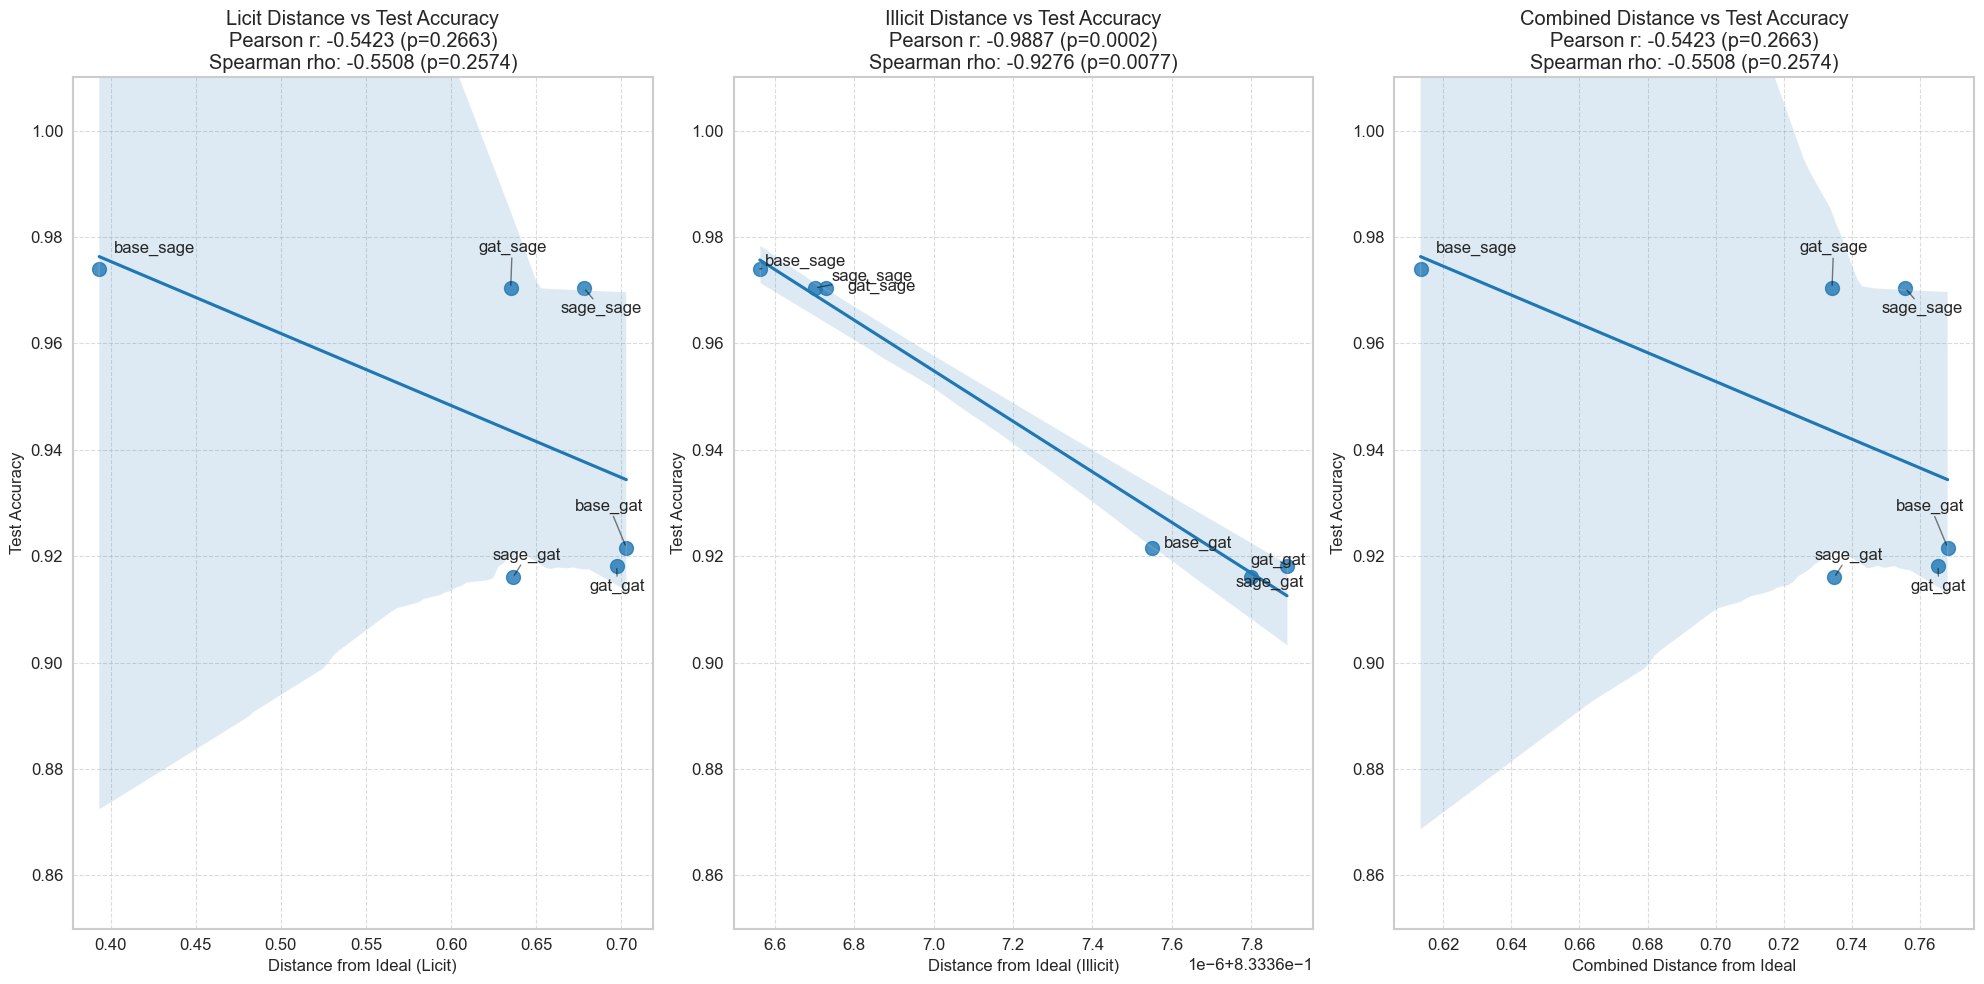

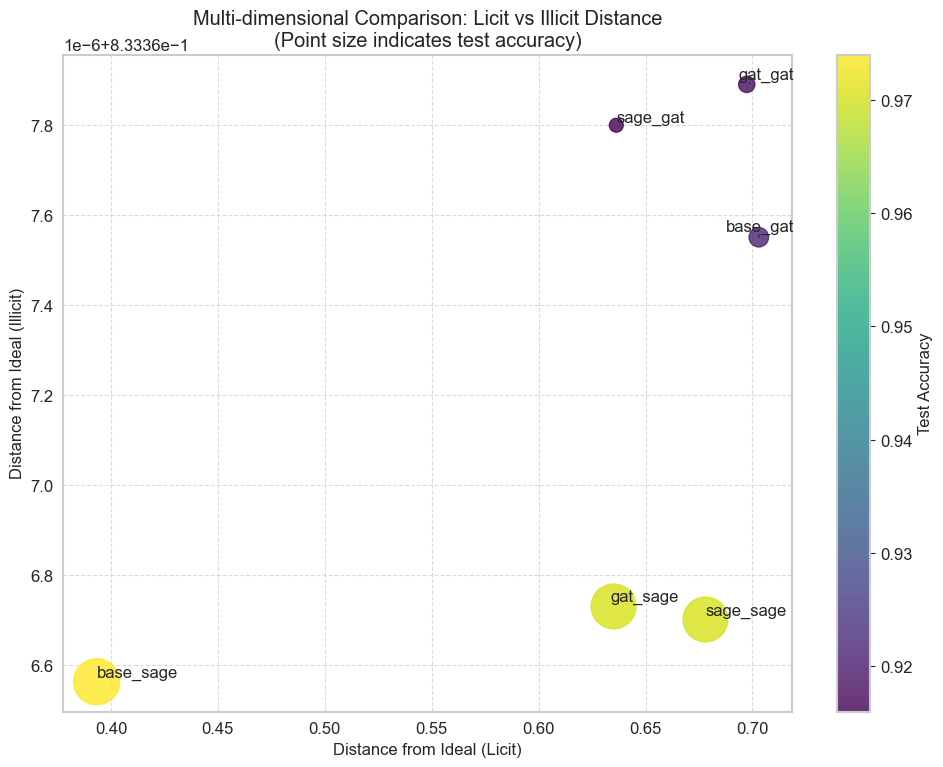

In [109]:
# Define paths to the CSV files
similarity_csv = 'output/comprehensive_analysis_20250410_201946/method_comparisons/normalized_similarity_summary.csv'
test_accuracy_csv = 'output/comprehensive_analysis_20250410_201946/comparison/summary_metrics.csv'

# Run the analysis
merged_data = plot_distance_from_ideal_vs_test_accuracy(similarity_csv, test_accuracy_csv)

## The formula for calculating the distance from ideal is:

There are six graph properties that are used to calculate the distance from ideal:

1. **Homophily**: Measures the tendency of nodes to connect with others of the same class (in this case, licit or illicit). 
   - In this implementation, we approximate it using edge-to-node ratio within each class
   - Higher values indicate stronger connections within the same class
   - Important for detecting clustered behavior of similar transaction patterns

2. **Density**: The ratio of actual connections to possible connections in the graph.
   - Calculated as `2 * |E| / (|V| * (|V| - 1))` where |E| is edge count and |V| is node count
   - Lower density in illicit subgraphs might suggest more isolated transaction patterns
   - Higher density in licit subgraphs can indicate normal financial ecosystem interactions

3. **Average Clustering Coefficient**: Measures the degree to which nodes tend to cluster together.
   - Calculated as the average of local clustering coefficients across all nodes
   - Higher values indicate more tightly-knit communities in the transaction network
   - Illicit networks may exhibit distinctive clustering patterns compared to legitimate ones

4. **Average Degree Centrality**: Measures the average influence of nodes in the network.
   - Calculated as the average of normalized node connection counts
   - Identifies how well-connected typical nodes are within each class
   - Helps distinguish between transaction patterns with many vs. few counterparties

5. **Average Betweenness Centrality**: Measures the extent to which nodes stand between others in the network.
   - Identifies nodes that serve as bridges between different parts of the network
   - Higher values may indicate "money mule" patterns in financial transaction graphs
   - Different betweenness patterns can distinguish legitimate hubs from suspicious intermediaries

6. **Largest Component Ratio**: Measures the fraction of nodes that belong to the largest connected component.
   - Calculated as size of largest component divided by total node count
   - Identifies how fragmented the subgraph is
   - Illicit networks might show different component structures than legitimate ones

Raw Similarity Calculation:
First, for any two metrics (original and predicted), the raw similarity is calculated as:
$$
\text{Raw Similarity}(v_1, v_2) =
\begin{cases}
1.0 & \text{if } v_1 = 0 \text{ and } v_2 = 0 \\
0.0 & \text{if } v_1 = 0 \text{ or } v_2 = 0 \\
1 - \min\left(\frac{|v_1 - v_2|}{\max(|v_1|, |v_2|)}, 1\right) & \text{otherwise}
\end{cases}
$$

Bootstrap-Normalized Similarity:
When using bootstrap statistics:
$$
\text{Bootstrap Normalized Similarity} =
\begin{cases}
1.0 & \text{if } \sigma_{\text{bootstrap}} = 0 \text{ and } |v_{\text{pred}} - v_{\text{train}}| = 0 \\
0.0 & \text{if } \sigma_{\text{bootstrap}} = 0 \text{ and } |v_{\text{pred}} - v_{\text{train}}| \neq 0 \\
\max\left(0, 1 - \min\left(\frac{|v_{\text{pred}} - v_{\text{train}}|}{\sigma_{\text{bootstrap}} \cdot 3}, 1\right)\right) & \text{otherwise}
\end{cases}
$$
Where:
$v_{\text{pred}}$ is the predicted value
$v_{\text{train}}$ is the training value
$\sigma_{\text{bootstrap}}$ is the standard deviation from bootstrap samples

Distance from Ideal:
The distance from ideal is simply:
$$
\text{Distance from Ideal} = |{\text{Normalized Similarity} - 1.0}|
$$

Combined Distance:
For combining licit and illicit metrics:
$$
\text{Combined Distance} = \frac{\text{Distance from Ideal}_{\text{licit}} + \text{Distance from Ideal}_{\text{illicit}}}{2}
$$

This formula quantifies how far a model's graph structural properties are from the ideal case (where normalized similarity equals 1.0), enabling you to identify models that best preserve the original graph's structural characteristics.